# RCC Predictions with PLS and RF Feature Selection

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 29APR2020 

_This is a static version of a Jupyter notebook, and work (documentation) is still in progress_ 

**Goals**: 
1. To merge NMR and MS Dataset. 

<a id="0"></a>

## Notebook Content

1.  [RCC Prediction in Model Cohort](#1)
2.  [RCC Prediction: Test Cohort](#2)
3.  [Chemical Information of Biomarkers](#3)


## Dataframes
-  The original form of the MS data from the Facundo Lab at Georgia tech is uploaded as the `dfMS` dataframe.
-  `MS-Labels` is the dataframe for Mass Spectrometry detected metabolites IDs, mode, retention time and formula
-  `MS` is the dataframe for the MS Peak Intensities
-  `MSData` is the dataframe for `all` the MS Peak Intensities with patient ID and Groups
-  `dfNMR` contains representative peaks for features/metabolites from NMR
-  `combined` is the NMR merged with the MS dataset. 
-  `combined_clinic` is the dataframe that contains all combined NMR and MS samples collected in the clinic. 
-  `PMdata`
-  `PMdata2`
-  `modelcohort`
-  `testcohort`
-  `qfeatures`
-  `MLfeatures??`
-  `MLfeatures2??`
-  `biomarker`
-  `biomarker2`
-  `MS_labels_bmarkers`
-  `MS_labels_qmarkers`

In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import scipy
#For Seaborn plots
import seaborn as sns; sns.set(style='white')
#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)

# 1. RCC Prediction in Model Cohort
<a id="1"></a>

In [11]:
# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)
import statsmodels as sms
from statsmodels.stats import multitest
from statistics import mean

# Machine Learning Libraries
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier

# Import Random Forest classifier, sklearn metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# test train split and K-fold validation
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import decomposition

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

# Plotly and Network Graph Libraries
import plotly as py
import plotly.graph_objs as go

import networkx as nx

py.offline.init_notebook_mode(connected=True)

In [12]:
print(sms.__version__)

0.10.1


#### Export Model Cohort Data

In [13]:
modelcohort = pd.read_excel('data/modelcohort.xlsx')

### a. Feature Selection 

### (i)  Select features with greater than 2-fold changes

Non-metabolic features in the `modelcohort` dataframe include the following: 
-  Sample ID
-  Patient ID
-  Collection
-  Gender
-  Race
-  BMI
-  Smoker
-  Age
-  Groups

In [14]:
NMRMS = modelcohort.drop(['Sample ID', 'Patient ID', 'Collection', 'Gender',
                         'Race', 'BMI', 'Smoker', 'Age'], axis=1)
Control = NMRMS[(NMRMS['Groups'] == 'Control')]
RCC = NMRMS[(NMRMS['Groups'] == 'RCC')]

dfmean = pd.DataFrame({'Features':NMRMS.drop(['Groups'], axis=1).mean(axis=0).index, 
                       'Control':Control.drop(['Groups'], axis=1).mean(axis=0).values,
                       'RCC':RCC.drop(['Groups'], axis=1).mean(axis=0).values})
dfmean.shape

(7145, 3)

In [15]:
cols = []
ctr_val = dfmean['Control']
rcc_val = dfmean['RCC']

for ctr, rcc in zip(ctr_val, rcc_val):
    ratio1 = ctr/rcc
    ratio2 = rcc/ctr
    if ratio1 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
    elif ratio2 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
xfold_feat = [val for sublist in cols for val in sublist] # flatten out list of list.
len(xfold_feat)

2104

### (ii) _t_-Test Feature Selection 

_T-Test Function_

In [16]:
def Ttest(metabolites, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the metabolites differences between two groups with 
    Benjamini-Hocberg FDR correction
    
    Inputs: 
    metabolites = A list containing names of metabolites
    dfControl = A pandas dataframe containing the control group metabolites data
    dfTreat =  A pandas dataframe containing the treatment group metabolites data
    alpha = alpha for statistical significant judgment, default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    ttest_dict = {}
    for metabolite in metabolites:
        statistic, pvalue =  scipy.stats.ttest_ind(dfControl[metabolite], 
                                               dfTreat[metabolite], 
                                               equal_var=var)
        ttest_dict[metabolite] = pvalue 
        # a dictionary containing name of metabolites and p value after t-test
    ttest = pd.DataFrame.from_dict(ttest_dict, orient='index') # the dictionary in pandas df
    ttest_list=list(ttest_dict.values()) #values (pvalues) of ttest result in a list
    reject, pval_corrected, _, _ = sms.stats.multitest.multipletests(ttest_list, 
                                                                 alpha=alpha, 
                                                                 method='fdr_bh')
    ttest_results = pd.DataFrame({'Metabolite': metabolites, 'T-test p-value': ttest_list, 
                              'FDR p-value': pval_corrected, 'Reject H0': reject})
    Table = ttest_results.sort_values(by=['FDR p-value'])
    return Table

In [17]:
# '''List of final metabolites set'''
metabolite_list = xfold_feat

# '''List of final metabolites set'''
ttest_result = Ttest(metabolite_list, Control, RCC, alpha=0.05, var=True)

# '''List of Statistically relevant metabolites'''
# Select metabolites with <0.05 FDR
stat_sig = ttest_result.loc[ttest_result['Reject H0'] == True]

# Select metabolites with <0.05 t-test
#stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
print("The total number of significant metabolites/Features is: ", len(stat_sig))

The total number of significant metabolites/Features is:  435


In [18]:
Feature = stat_sig['Metabolite'].values.tolist(); # stat MS significant metabolites
MLfeatures = NMRMS[Feature] # p<0.05 metabolites
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

In [19]:
MLfeatures.shape

(62, 435)

In [20]:
MLfeatures.astype(float);

In [21]:
correlated_features = set()
correlation_matrix = MLfeatures.astype(float).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [22]:
MLfeatures = MLfeatures.drop(correlated_features, axis=1)
MLfeatures.shape

(62, 132)

### (iii). PLSRegression for Feature Selection

Reference: 
-  https://nirpyresearch.com/variable-selection-method-pls-python/
-  https://github.com/scikit-learn/scikit-learn/issues/7050
-  https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html

In [23]:
dfgrp = NMRMS.filter(['Groups'], axis=1)
# convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
# Features and groups
X = MLfeatures.values
y = dfgroup.values

In [24]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [25]:
pls = PLSRegression()
pls.fit(X, y)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

*PLS coefficient of the fit*

In [26]:
pls.coef_[:,0];

In [27]:
def vip(x, y, model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

In [28]:
vip_list = vip(X, y, pls.fit(X, y))

In [29]:
list_of_tuples = list(zip(MLfeatures.columns, vip_list))
df_feat = pd.DataFrame(list_of_tuples, columns = ['Metabolites', 'Importance'])
df_feat = df_feat.sort_values(by='Importance', ascending=False)
#df_feat = df_feat.loc[df_feat['Ranking'] == True]
df_feat.head(20);

In [30]:
PLSfeatures = NMRMS[df_feat['Metabolites'][:20].tolist()] # top 20 ML PLS features

### (iv) Recursive Feature Elimination for Feature Selection

In [31]:
dfgrp = NMRMS.filter(['Groups'], axis=1)
# convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
# Features and groups
X = MLfeatures.values
y = dfgroup.values

Optimal number of features : 103


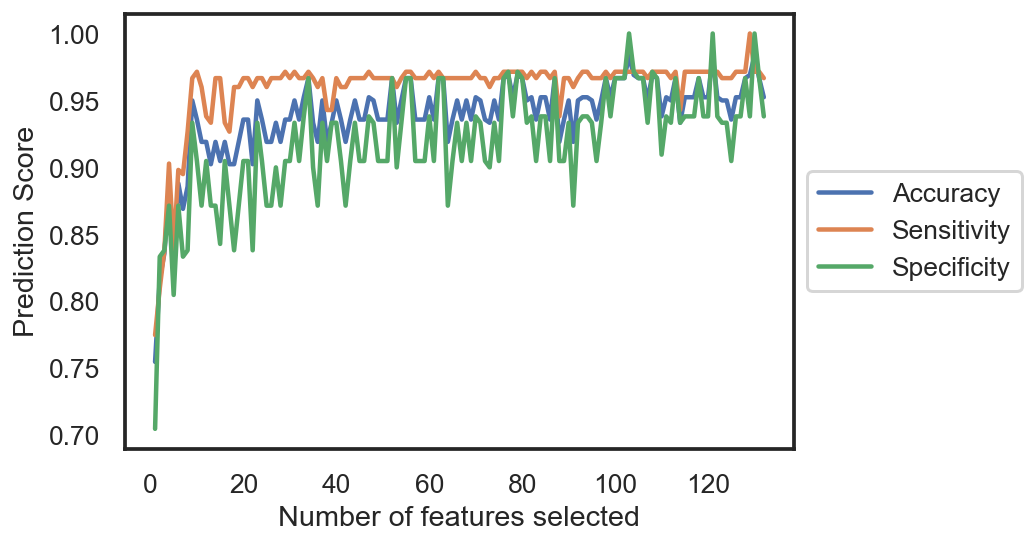

In [32]:
# Create the RFE object and compute a cross-validated score.
#RF= RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, class_weight="balanced",  random_state=42)
RF=RandomForestClassifier(n_estimators=100, random_state=42)


# Create a custom CV so we can seed with random state
rsk = model_selection.StratifiedKFold(n_splits=5, random_state=42)

# The "accuracy" scoring is proportional to the number of correct
# classifications
accuracy = RFECV(estimator=RF, cv=rsk, scoring='accuracy') #'accuracy'
precision = RFECV(estimator=RF, cv=rsk, scoring='precision') #'accuracy'
recall = RFECV(estimator=RF, cv=rsk, scoring='recall') #'accuracy'

accuracy.fit(X, y)
precision.fit(X, y)
recall.fit(X,y)

print("Optimal number of features : %d" % accuracy.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Prediction Score")
plt.plot(range(1, len(accuracy.grid_scores_) + 1), 
         accuracy.grid_scores_, label='Accuracy')
plt.plot(range(1, len(precision.grid_scores_) + 1), 
         precision.grid_scores_, label='Sensitivity')
plt.plot(range(1, len(recall.grid_scores_) + 1), 
         recall.grid_scores_, label='Specificity')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [33]:
print ("The highest accuracy features is {}%" .format(max(accuracy.grid_scores_)*100))

The highest accuracy features is 98.33333333333331%


Rank features by the features importance from `RF-RFECV` algorithms. 

In [34]:
list_of_tuples = list(zip(MLfeatures.columns, 
                          accuracy.estimator_.feature_importances_, 
                          accuracy.support_, accuracy.ranking_))
df_feat = pd.DataFrame(list_of_tuples, columns = ['Metabolites', 'Importance', 
                                                  'Selected', 'Ranking'])
df_feat = df_feat.sort_values(by='Importance', ascending=False)
#df_feat = df_feat.loc[df_feat['Ranking'] == True]
df_feat.head(20)

Metabolites  Importance  Selected  Ranking
1          3872    0.067131      True        1
2          3675    0.051305      True        1
66         2809    0.050428     False       25
5          4080    0.046002      True        1
58         2577    0.043519      True        1
4          6261    0.035327      True        1
7          3804    0.033225      True        1
11         3141    0.030105      True        1
0          2102    0.028605      True        1
61         5110    0.021525     False       26
40         3160    0.020974      True        1
89         1771    0.020222      True        1
14         1481    0.019528      True        1
3           720    0.017528      True        1
46         6389    0.017167      True        1
59         5507    0.015885      True        1
65         2005    0.015772      True        1
6          6262    0.014357      True        1
38         6385    0.013761      True        1
47         4408    0.013186      True        1

_Select the features with the top 20 RF feature importance score or all features selected by the RFECV-RF_

In order to use the top features with the lowest q-values, use the the `stat_sig` dataframes

In [35]:
RFfeatures = NMRMS[df_feat['Metabolites'][:20].tolist()] # top 20 ML features
#MLfeatures = NMRMS[df_feat['Metabolites'].tolist()] # all selected features from RFECV-RF
#MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

#### Converge the PLS-DA and RF features.

In [36]:
PLSfeatures.columns

Index([2102, 3872,  720, 3675, 4080, 6261, 6262, 3804,  819, 1701, 5887, 3141,
       1481, 6095, 2455, 3526,  278, 7087, 2850, 4766],
      dtype='object')

In [37]:
RFfeatures.columns

Index([3872, 3675, 2809, 4080, 2577, 6261, 3804, 3141, 2102, 5110, 3160, 1771,
       1481,  720, 6389, 5507, 2005, 6262, 6385, 4408],
      dtype='object')

In [38]:
final_features = set(PLSfeatures) - (set(PLSfeatures) - set(RFfeatures))

In [39]:
final_features

{720, 1481, 2102, 3141, 3675, 3804, 3872, 4080, 6261, 6262}

In [40]:
# Import MS_labels
MS_labels = pd.read_excel('data/MS_labels.xlsx')

In [41]:
MS_labels[MS_labels.ID.isin(final_features)]

ID      Mode  RT [min]                                 Name  \
719    720  positive     2.562  2-Aminoacetophenone;O-Acetylaniline   
1480  1481  positive     6.290                                 1481   
2101  2102  positive     3.449    N,N-Diisopropylethylamine (DIPEA)   
3140  3141  positive     1.133                                 3141   
3674  3675  positive     1.184                                 3675   
3803  3804  positive     2.595                                 3804   
3871  3872  positive     4.049                                 3872   
4079  4080  positive     0.821                                 4080   
6260  6261  negative     2.591                                 6261   
6261  6262  negative     2.667                                 6262   

                 Formula  
719            C8 H9 N O  
1480                 NaN  
2101            C8 H19 N  
3140      C7 H18 N8 O6 S  
3674                 NaN  
3803       C4 H12 N O6 P  
3871                 NaN  
4079  C10 H21 N3 O8 P2 S  
6260      C9 H18 N9 O2 P  
6261     C10 H20 N9 O5 P

In [42]:
MLfeatures = NMRMS[list(final_features)]
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

### c. Machine Learning for RCC Prediction

In [43]:
from sklearn.metrics import confusion_matrix

_Machine Learning Model Function_

In [69]:
def ml_model(X, y, model, kfold=5):
    
    '''
    FUNCTION: 
    A  machine learning function under Kfold cross validation conditions  
    
    DEPENDENCY: 
    Various Sklearn packages
    from sklearn import metrics
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import KFold
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import roc_auc_score
    
    INPUTS: 
    X = numpy.ndaarray: features
    y = numpy.ndaarray: Labels encoded as 0s and 1s. 
    model = machine learning model
    kfold = numeric. K-fold default is 5. 
    
    OUTPUT: 
    A list containing the following machine learning metrics: 
    Area Under the Curve(AUC), Accuracy (ACC), Precision (PRE), 
    Recall (REC), F1-core (FS), Matthew's Correlation Coefficient (MCC). 
    
    '''

    
    cv = model_selection.StratifiedKFold(n_splits=kfold, random_state=42, shuffle=True)
    # define 'list' of various metrics
    AUC, ACC, PRE, REC, FS, MCC, SPE = [], [], [], [], [], [], [] 
    performance = []
    
    for (train, test), i in zip(cv.split(X, y), range(kfold)):
        # training the model
        model.fit(X[train], y[train])
        y_pred = model.predict(X[test])
        
        #Retrieving metrics after testing
        modelprobs = model.predict_proba(X[test])
        fpr, tpr, thresholds = metrics.roc_curve(y[test], modelprobs[:,1])
        roc_auc = auc(fpr, tpr)
        accuracy = metrics.accuracy_score(y[test], y_pred)
        precision = metrics.precision_score(y[test], y_pred)
        recall = metrics.recall_score(y[test], y_pred)
        f1_score = metrics.f1_score(y[test], y_pred)
        mcc = metrics.matthews_corrcoef(y[test], y_pred)
        # coding specificity
        tn, fp, fn, tp = confusion_matrix(y[test], y_pred).ravel()
        specificity = tn / (tn+fp)
        # append metrics to list
        AUC.append(roc_auc)
        ACC.append(accuracy)
        PRE.append(precision)
        REC.append(recall)
        FS.append(f1_score)
        MCC.append(mcc)
        SPE.append(specificity)
        
    return AUC, ACC, PRE, REC, FS, MCC, SPE

_Machine Learning Metric Plot Function_

In [45]:
def MLmetric_plot(data_dict, y_label):
    '''
    FUNCTION: 
    To plot machine learning metrics from ml_model function.   
    
    DEPENDENCY: 
    Pandas, seaborn, 
    
    INPUTS: 
    data_dict = dictionary. Contains ML model name and metric scores
    y_label = String. Label for the y-axis 
    
    OUTPUT: 
    Figure
    
    '''
    
    fig = pd.DataFrame(data=data_dict)
    splot = sns.barplot(x='Model', y=y_label, data=fig);
    #splot = sns.swarmplot(data=ACCfig, orient='h', s=10, alpha=0.7, color=".25");
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.2f'), 
                              (p.get_x() + p.get_width() / 2., p.get_height()), 
                              ha = 'center', va = 'center', xytext = (6, 15), 
                              textcoords = 'offset points')
    return splot
#plt.savefig('testACC.svg', dpi=300)



Define features and labels.

In [46]:
dfgrp = NMRMS.filter(['Groups'], axis=1)
#convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
X = MLfeatures.values
y = dfgroup.values

### Grid Search: Random Forest

[Method Reference: towardsdatascience.com](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) <br>
[GridSearchCV sklearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [47]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [50, 100, 150, 200]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)

# Create a custom CV so we can seed with random state
rsk = model_selection.StratifiedKFold(n_splits=5, random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = rsk, scoring = 'accuracy', n_jobs = -1, verbose = 2)

In [48]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  3.0min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

In [49]:
grid_search.best_score_

0.9516129032258065

In [50]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.063637      0.002641         0.006457        0.000837   
1         0.134650      0.009893         0.018138        0.011141   
2         0.263593      0.026784         0.029122        0.008095   
3         0.347330      0.051654         0.038250        0.006493   
4         0.085471      0.009259         0.011927        0.006110   
5         0.174530      0.012543         0.014366        0.002322   
6         0.259178      0.044178         0.021389        0.003880   
7         0.287583      0.026984         0.022728        0.000947   
8         0.063554      0.002059         0.006150        0.000211   
9         0.134652      0.011343         0.012963        0.001324   
10        0.291817      0.009567         0.025470        0.004984   
11        0.347396      0.035104         0.027004        0.004876   
12        0.071189      0.013375         0.007094        0.002022   
13        0.207969      0.019418         0.018549        0.002004   
14        0.313044      0.053519         0.025799        0.009206   
15        0.416825      0.023604         0.047576        0.026918   
16        0.112461      0.035588         0.008417        0.002015   
17        0.175849      0.046491         0.021165        0.008562   
18        0.288624      0.012916         0.024366        0.009412   
19        0.302256      0.036189         0.030880        0.009648   
20        0.100288      0.027459         0.012723        0.003576   
21        0.181372      0.020854         0.012572        0.001266   
22        0.219227      0.017924         0.018954        0.002366   
23        0.330397      0.060322         0.033188        0.004652   
24        0.102083      0.015370         0.010646        0.003684   
25        0.155461      0.009820         0.012334        0.001185   
26        0.217230      0.010766         0.021362        0.004410   
27        0.324602      0.026083         0.030250        0.006971   
28        0.069272      0.003443         0.007100        0.001215   
29        0.132226      0.006127         0.012941        0.002281   
..             ...           ...              ...             ...   
690       0.198795      0.014787         0.019011        0.002779   
691       0.275581      0.014295         0.023196        0.001839   
692       0.067643      0.002407         0.006244        0.000390   
693       0.137600      0.006369         0.013277        0.002050   
694       0.202877      0.004585         0.018673        0.002534   
695       0.273565      0.004027         0.025617        0.001638   
696       0.071833      0.004066         0.008312        0.002824   
697       0.141449      0.008225         0.015160        0.003762   
698       0.242803      0.020908         0.021755        0.006413   
699       0.306219      0.011864         0.028186        0.003271   
700       0.083005      0.004805         0.006325        0.000714   
701       0.131786      0.007172         0.012266        0.001035   
702       0.251255      0.020113         0.023019        0.003594   
703       0.295660      0.017912         0.025268        0.002018   
704       0.068465      0.004887         0.007424        0.001538   
705       0.157845      0.006706         0.017370        0.005480   
706       0.231836      0.015236         0.018923        0.001131   
707       0.297400      0.013097         0.026731        0.004154   
708       0.069086      0.006635         0.007136        0.001718   
709       0.180847      0.029135         0.021666        0.007301   
710       0.280533      0.020644         0.029321        0.005833   
711       0.349804      0.013138         0.026598        0.005827   
712       0.074028      0.008152         0.008750        0.002935   
713       0.182060      0.021862         0.013981        0.001003   
714       0.199123      0.004363         0.019069        0.002374   
715       0.295120      0.032010         0.027043        0.003684   
716

### Grid Search: SVM-RBF

In [51]:
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0]}

svm_cls = svm.SVC(random_state=42)
grid_search = GridSearchCV(svm_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [52]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}

In [53]:
grid_search.best_score_

0.9516129032258065

In [54]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.001551      0.000813         0.000743        0.000370     0.1   
1        0.000884      0.000136         0.001200        0.001052     0.1   
2        0.001245      0.000505         0.000697        0.000215     0.1   
3        0.001435      0.001102         0.000782        0.000442     0.1   
4        0.001409      0.001397         0.000448        0.000058     0.1   
5        0.000656      0.000067         0.000414        0.000023       1   
6        0.001157      0.001194         0.000414        0.000058       1   
7        0.000715      0.000132         0.001038        0.001119       1   
8        0.000666      0.000058         0.006405        0.011864       1   
9        0.001727      0.001387         0.000520        0.000055       1   
10       0.000736      0.000069         0.000591        0.000208      10   
11       0.000712      0.000087         0.000447        0.000020      10   
12       0.001233      0.000721         0.000663        0.000241      10   
13       0.000724      0.000034         0.000705        0.000239      10   
14       0.001830      0.002192         0.000433        0.000024      10   
15       0.000661      0.000125         0.001896        0.002813     100   
16       0.000955      0.000327         0.000653        0.000388     100   
17       0.000880      0.000168         0.000873        0.000373     100   
18       0.000813      0.000110         0.001013        0.000936     100   
19       0.001413      0.001095         0.000483        0.000048     100   

   param_gamma param_kernel                                      params  \
0         0.01          rbf  {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}   
1         0.03          rbf  {'C': 0.1, 'gamma': 0.03, 'kernel': 'rbf'}   
2          0.1          rbf   {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}   
3          0.3          rbf   {'C': 0.1, 'gamma': 0.3, 'kernel': 'rbf'}   
4            1          rbf   {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}   
5         0.01          rbf    {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}   
6         0.03          rbf    {'C': 1, 'gamma': 0.03, 'kernel': 'rbf'}   
7          0.1          rbf     {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}   
8          0.3          rbf     {'C': 1, 'gamma': 0.3, 'kernel': 'rbf'}   
9            1          rbf     {'C': 1, 'gamma': 1.0, 'kernel': 'rbf'}   
10        0.01          rbf   {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}   
11        0.03          rbf   {'C': 10, 'gamma': 0.03, 'kernel': 'rbf'}   
12         0.1          rbf    {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}   
13         0.3          rbf    {'C': 10, 'gamma': 0.3, 'kernel': 'rbf'}   
14           1          rbf    {'C': 10, 'gamma': 1.0, 'kernel': 'rbf'}   
15        0.01          rbf  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}   
16        0.03          rbf  {'C': 100, 'gamma': 0.03, 'kernel': 'rbf'}   
17         0.1          rbf   {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}   
18         0.3          rbf   {'C': 100, 'gamma': 0.3, 'kernel': 'rbf'}   
19           1          rbf   {'C': 100, 'gamma': 1.0, 'kernel': 'rbf'}   

    split0_test_score  split1_test_score  split2_test_score  \
0            0.857143           0.750000           0.916667   
1            0.928571           0.750000           0.916667   
2            0.928571           0.916667           1.000000   
3            0.928571           0.833333           0.833333   
4            0.857143           0.583333           0.833333   
5            0.857143           0.750000           1.000000   
6            0.928571           0.833333           1.000000   
7            0.857143           0.833333           0.916667   
8            0.857143           1.000000           0.833333   
9            0.857143           0.750000           0.833333   
10           0.857143           0.833333           0.916667   
11           0.928571           0.916667           0.833333   
12          

### Grid Search: Lin-SVM

In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 5, 10.]}

svm_cls = svm.SVC(random_state=42)
grid_search = GridSearchCV(svm_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [56]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.1s finished


{'C': 0.1, 'kernel': 'linear'}

In [57]:
grid_search.best_score_

0.9032258064516129

In [58]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.000873      0.000072         0.000481        0.000064   0.001   
1       0.000729      0.000065         0.000414        0.000013    0.01   
2       0.000720      0.000094         0.000425        0.000052     0.1   
3       0.000725      0.000220         0.000420        0.000124       1   
4       0.000633      0.000051         0.000417        0.000165       5   
5       0.000510      0.000102         0.000293        0.000072      10   

  param_kernel                            params  split0_test_score  \
0       linear  {'C': 0.001, 'kernel': 'linear'}           0.785714   
1       linear   {'C': 0.01, 'kernel': 'linear'}           0.857143   
2       linear    {'C': 0.1, 'kernel': 'linear'}           0.857143   
3       linear      {'C': 1, 'kernel': 'linear'}           0.857143   
4       linear      {'C': 5, 'kernel': 'linear'}           0.857143   
5       linear   {'C': 10.0, 'kernel': 'linear'}           0.857143   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.666667           0.833333           0.833333           0.750000   
1           0.750000           0.916667           0.833333           0.916667   
2           0.833333           0.916667           0.916667           1.000000   
3           0.916667           0.833333           0.916667           0.833333   
4           0.916667           0.833333           0.916667           0.833333   
5           1.000000           0.916667           0.916667           0.833333   

   mean_test_score  std_test_score  rank_test_score  
0         0.774194        0.061114                6  
1         0.854839        0.060809                5  
2         0.903226        0.057511                1  
3         0.870968        0.037414                3  
4         0.870968        0.037414                3  
5         0.903226        0.057511                1

### Grid Search: kNN

In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': list(range(3,30)), 'p': [1,2]}

knn_cls = KNeighborsClassifier()
              
grid_search = GridSearchCV(knn_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [60]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    0.3s finished


{'n_neighbors': 4, 'p': 1}

In [61]:
grid_search.best_score_

0.9516129032258065

In [62]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.001425      0.001087         0.002088        0.000583   
1        0.000568      0.000101         0.001650        0.000443   
2        0.000587      0.000076         0.001677        0.000116   
3        0.000676      0.000136         0.003230        0.002838   
4        0.000725      0.000335         0.001609        0.000064   
5        0.004110      0.006854         0.001875        0.000290   
6        0.000667      0.000221         0.001763        0.000206   
7        0.000678      0.000108         0.003186        0.002669   
8        0.000621      0.000046         0.002178        0.000848   
9        0.000623      0.000030         0.001817        0.000050   
10       0.000678      0.000166         0.001776        0.000178   
11       0.000640      0.000058         0.003782        0.002056   
12       0.000527      0.000026         0.003682        0.004087   
13       0.002624      0.003692         0.002181        0.001068   
14       0.004068      0.006856         0.001739        0.000161   
15       0.000606      0.000034         0.001900        0.000189   
16       0.000619      0.000049         0.001825        0.000255   
17       0.000723      0.000200         0.003005        0.001602   
18       0.001729      0.002215         0.001963        0.000479   
19       0.000613      0.000032         0.001748        0.000035   
20       0.000828      0.000207         0.002017        0.000349   
21       0.000572      0.000024         0.001678        0.000033   
22       0.000613      0.000073         0.001754        0.000115   
23       0.000542      0.000014         0.001623        0.000058   
24       0.000608      0.000027         0.001894        0.000100   
25       0.000696      0.000193         0.001903        0.000315   
26       0.000731      0.000221         0.001972        0.000354   
27       0.000611      0.000071         0.003273        0.003082   
28       0.000588      0.000071         0.003456        0.003575   
29       0.000651      0.000167         0.002444        0.001281   
30       0.000699      0.000204         0.006886        0.009013   
31       0.000654      0.000101         0.001723        0.000090   
32       0.000758      0.000267         0.001814        0.000257   
33       0.000622      0.000045         0.002884        0.002108   
34       0.000598      0.000048         0.002762        0.001411   
35       0.000998      0.000426         0.005027        0.006003   
36       0.000654      0.000072         0.003567        0.002568   
37       0.000640      0.000089         0.002199        0.000411   
38       0.000602      0.000044         0.001945        0.000569   
39       0.000653      0.000074         0.003906        0.002419   
40       0.000606      0.000058         0.002015        0.000267   
41       0.000610      0.000064         0.002126        0.000756   
42       0.002894      0.004732         0.001810        0.000146   
43       0.002583      0.003929         0.003188        0.001746   
44       0.000453      0.000030         0.003253        0.002070   
45       0.000472      0.000039         0.002866        0.002119   
46       0.000502      0.000065         0.002234        0.000542   
47       0.000448      0.000032         0.004027        0.003398   
48       0.000623      0.000276         0.002028        0.000537   
49       0.000629      0.000334         0.002095        0.000606   
50       0.000470      0.000036         0.006187        0.005843   
51       0.000454      0.000029         0.002802        0.002238   
52       0.000518      0.000207         0.003556        0.003364   
53       0.001027      0.001130         0.001953        0.001204   

   param_n_neighbors param_p                       params  split0_test_score  \
0                  3       1   {'n_neighbors': 3, 'p': 1}           0.928571   
1                  3       2   {'n_neighbors': 3, 'p': 2}           0.857143   
2                  4   

### Train Machine Learning Models.

In [73]:
# Random Forest

#RF=RandomForestClassifier(n_estimators=100, random_state=123)
RF=RandomForestClassifier(n_estimators=50, min_samples_split=2, 
                          min_samples_leaf=2, max_features='auto', max_depth=10, 
                          bootstrap=True, random_state=42)
metric = ml_model(X, y, RF)
RF_AUC, RF_ACC, RF_PRE, RF_REC, RF_FS, RF_MCC, RF_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


# Linear-SVM
linsvm = svm.SVC(C = 0.1, kernel = 'linear', probability=True, random_state=42)
metric = ml_model(X, y, linsvm)
linsvm_AUC, linsvm_ACC, linsvm_PRE, linsvm_REC, linsvm_FS, linsvm_MCC, linsvm_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


# SVM
#clf = svm.SVC(kernel='linear', probability=True)
clf = svm.SVC(C = 0.1, gamma = 0.1, kernel = 'rbf', probability=True, random_state=42)
metric = ml_model(X, y, clf)
clf_AUC, clf_ACC, clf_PRE, clf_REC, clf_FS, clf_MCC, clf_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# KNN
knn = KNeighborsClassifier(n_neighbors=4, p=1)
metric = ml_model(X, y, knn)
KNN_AUC, KNN_ACC, KNN_PRE, KNN_REC, KNN_FS, KNN_MCC, KNN_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]



#Others....

# Bagging
BAG=BaggingClassifier(n_estimators=100, random_state=123)
metric = ml_model(X, y, BAG)
BAG_AUC, BAG_ACC, BAG_PRE, BAG_REC, BAG_FS, BAG_MCC = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5]
# Gradient Boosting
GBC=GradientBoostingClassifier(n_estimators=100, random_state=123)
metric = ml_model(X, y, GBC)
GBC_AUC, GBC_ACC, GBC_PRE, GBC_REC, GBC_FS, GBC_MCC = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5]

**AUC**

In [74]:
sns.set_context('talk', font_scale=0.8)

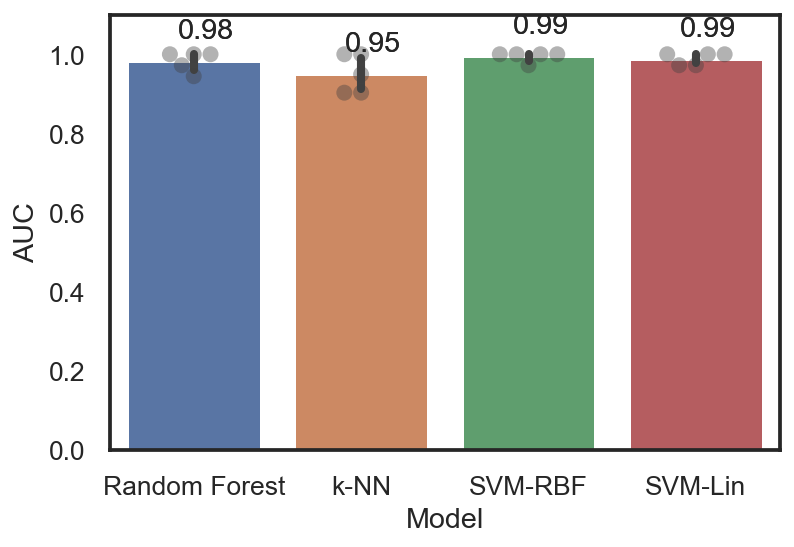

In [82]:
AUCfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'AUC':[mean(RF_AUC), mean(KNN_AUC), mean(clf_AUC), mean(linsvm_AUC)]}

afig = {'RF': RF_AUC, 'KNN': KNN_AUC, 'SVM': clf_AUC, 'Lin-SVM': linsvm_AUC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(AUCfig, 'AUC');
#plt.title('ML Model AUC Comparison for RCC prediction');

**Accuracy**

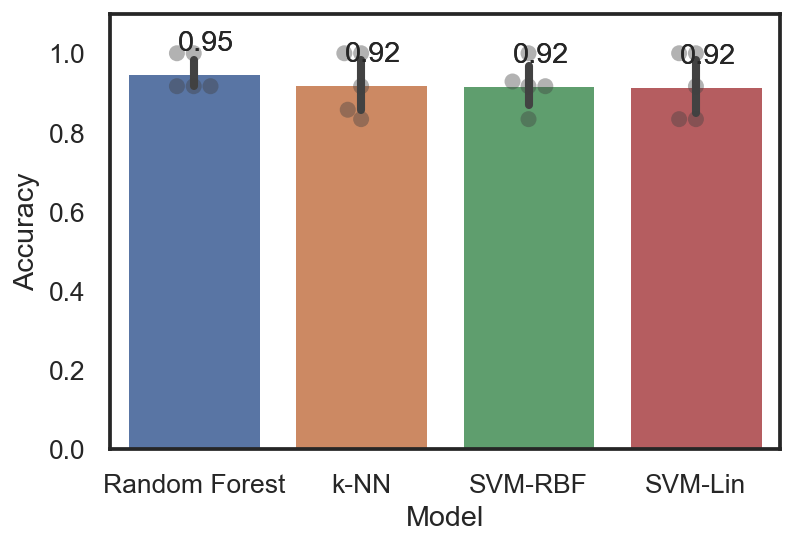

In [83]:
ACC_fig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Accuracy':[mean(RF_ACC), mean(KNN_ACC), mean(clf_ACC), mean(linsvm_ACC)]}

afig = {'RF': RF_ACC, 'KNN': KNN_ACC, 'SVM': clf_ACC, 'Lin-SVM': linsvm_ACC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(ACC_fig, 'Accuracy');
#plt.title('ML Model Accuracy Comparison for RCC prediction');

**Precision**

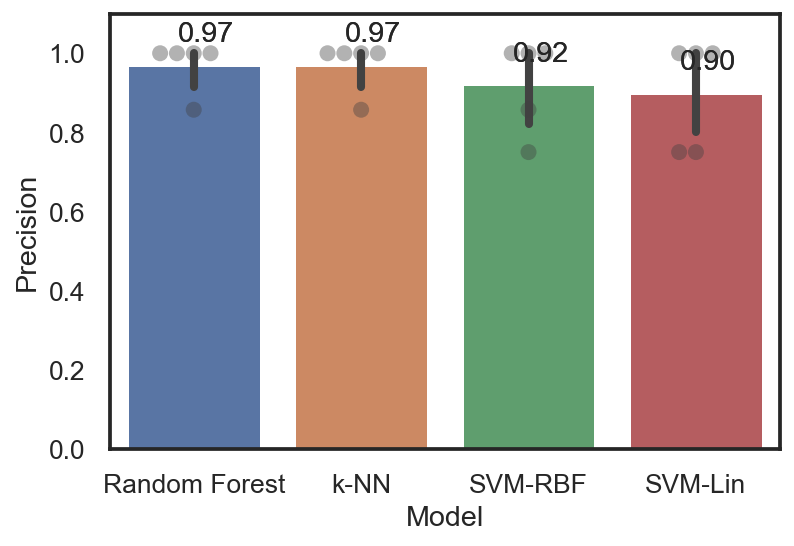

In [84]:
PREfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Precision':[mean(RF_PRE), mean(KNN_PRE), mean(clf_PRE), mean(linsvm_PRE)]}

afig = {'RF': RF_PRE, 'KNN': KNN_PRE, 'SVM': clf_PRE, 'Lin-SVM': linsvm_PRE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(PREfig, 'Precision');
#plt.title('ML Model Sensitivity (Precision) Comparison for RCC prediction');

**Recall**

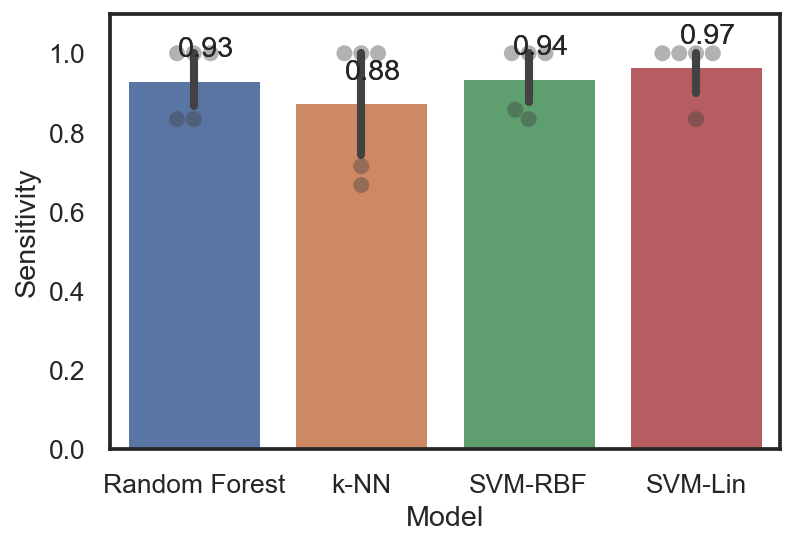

In [90]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Sensitivity':[mean(RF_REC), mean(KNN_REC), mean(clf_REC), mean(linsvm_REC)]}

afig = {'RF': RF_REC, 'KNN': KNN_REC, 'SVM': clf_REC, 'Lin-SVM': linsvm_REC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'Sensitivity');
#plt.title('ML Model Specificity (Recall) Comparison for RCC prediction');

**F1 Score**

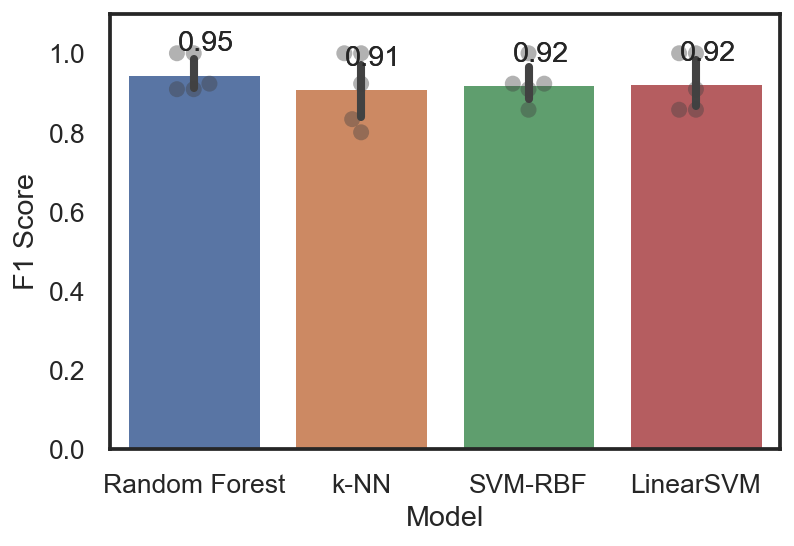

In [87]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'F1 Score':[mean(RF_FS), mean(KNN_FS), mean(clf_FS), mean(linsvm_FS)]}

afig = {'RF': RF_FS, 'KNN': KNN_FS, 'SVM': clf_FS, 'Lin-SVM': linsvm_FS}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'F1 Score');
#plt.title('ML Model F1 Score Comparison for RCC prediction');

**Specificity**

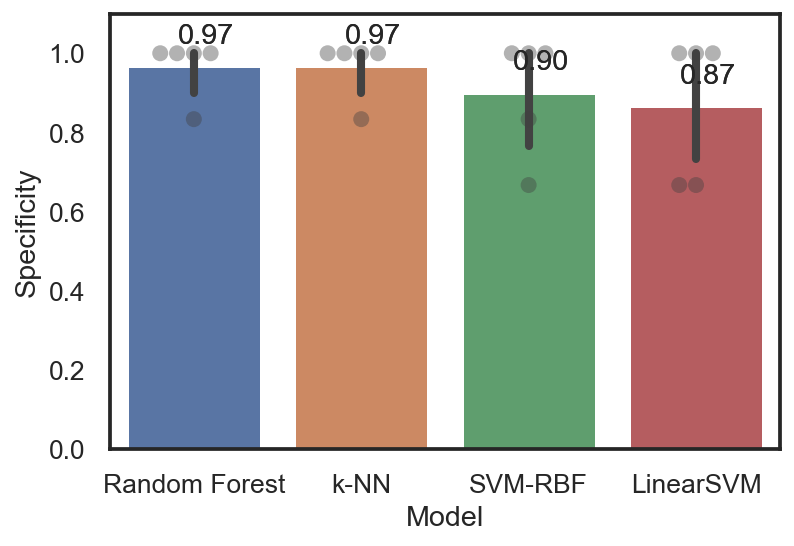

In [89]:
SPEfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'Specificity':[mean(RF_SPE), mean(KNN_SPE), mean(clf_SPE), mean(linsvm_SPE)]}

afig = {'RF': RF_SPE, 'KNN': KNN_SPE, 'SVM': clf_SPE, 'Lin-SVM': linsvm_SPE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(SPEfig, 'Specificity');
#plt.title('ML Model F1 Score Comparison for RCC prediction');

### Chemical Information of the Biomarkers

In [91]:
# Import MS_labels
MS_labels = pd.read_excel('data/MS_labels.xlsx')

In [92]:
MS_labels[MS_labels.ID.isin(MLfeatures.columns)]

ID      Mode  RT [min]                                 Name  \
719    720  positive     2.562  2-Aminoacetophenone;O-Acetylaniline   
1480  1481  positive     6.290                                 1481   
2101  2102  positive     3.449    N,N-Diisopropylethylamine (DIPEA)   
3140  3141  positive     1.133                                 3141   
3674  3675  positive     1.184                                 3675   
3803  3804  positive     2.595                                 3804   
3871  3872  positive     4.049                                 3872   
4079  4080  positive     0.821                                 4080   
6260  6261  negative     2.591                                 6261   
6261  6262  negative     2.667                                 6262   

                 Formula  
719            C8 H9 N O  
1480                 NaN  
2101            C8 H19 N  
3140      C7 H18 N8 O6 S  
3674                 NaN  
3803       C4 H12 N O6 P  
3871                 NaN  
4079  C10 H21 N3 O8 P2 S  
6260      C9 H18 N9 O2 P  
6261     C10 H20 N9 O5 P

An alternative way to plot the feature importance/

feature_imp = pd.DataFrame({'Features': MLfeatures.columns, 
                           'Importance': RF.feature_importances_})
feature_imp.sort_values(by='Importance', ascending=True, inplace=True);
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp['Features'], 
            y=feature_imp['Importance']);

In [93]:
feature_imp = pd.Series(RF.feature_importances_,
                        index=MLfeatures.columns).sort_values(ascending=False)

No handles with labels found to put in legend.


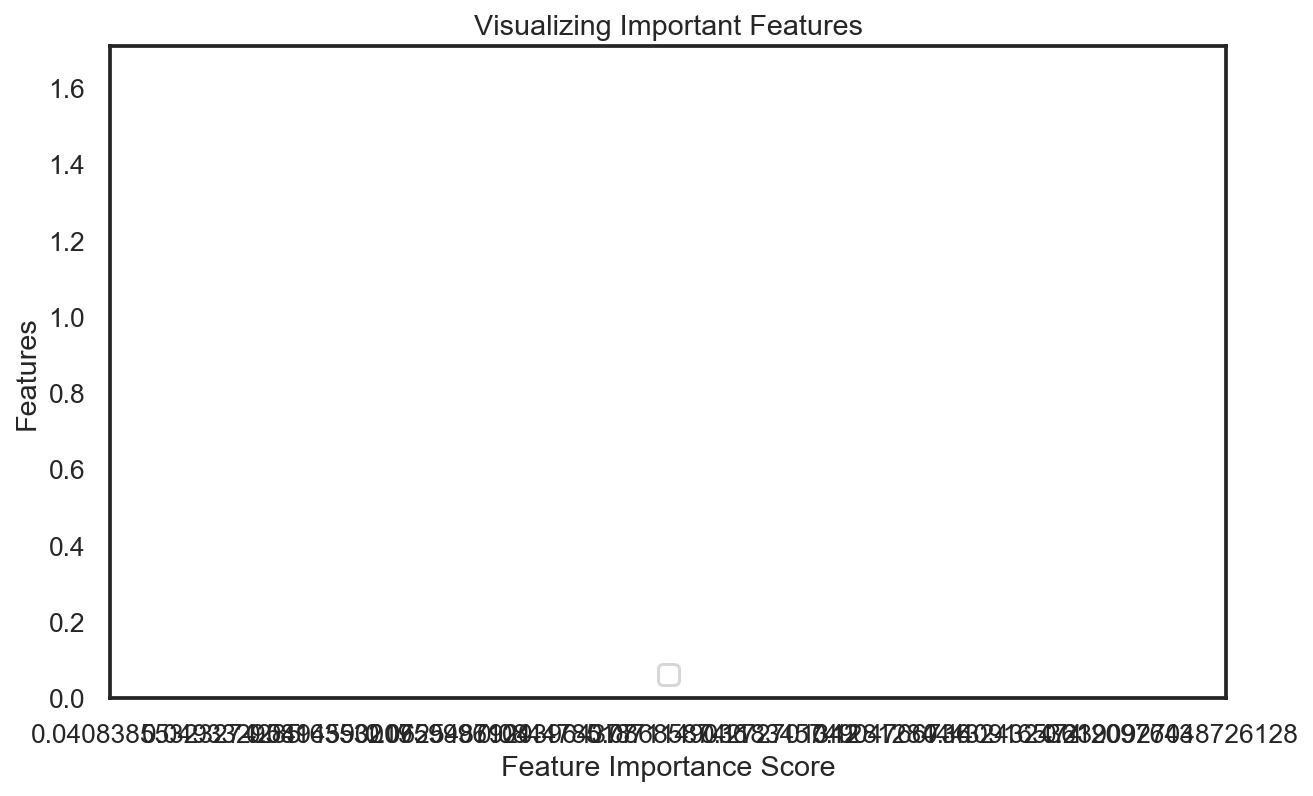

In [94]:
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
#plt.savefig('RF_Features.svg', dpi=300)
plt.show()

### d. Potential Biomarkers: PCA, HCA, Boxplot Visualization

In [95]:
#biomarker_feat = dummydf[df_feat['Metabolites']]
#biomarker_feat =(biomarker_feat - biomarker_feat.mean(axis=0))/biomarker_feat.std(axis=0)
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

_Rename column in biomarker dataframe to reduce length of feature name_

In [96]:
biomarker.rename(columns={'4-(2-Aminoethyl)benzenesulfonylfluoride':'AEBSF',
                          'N,N-Diisopropylethylamine (DIPEA)':'DIPEA',
                          '2-Aminoacetophenone;O-Acetylaniline':'O-Acetylaniline'}, 
                 inplace=True)

**p and q values associated with the metabolite panel in the model cohort**

In [97]:
stat_sig[stat_sig.Metabolite.isin(biomarker.columns)]

Metabolite  T-test p-value  FDR p-value  Reject H0
815        2102    7.480753e-08     0.000157       True
1374       3872    2.707590e-07     0.000285       True
1321       3675    4.976800e-07     0.000349       True
283         720    1.466276e-06     0.000441       True
1880       6261    1.048271e-06     0.000441       True
1430       4080    2.719035e-06     0.000554       True
1881       6262    3.088222e-06     0.000554       True
1354       3804    4.246283e-06     0.000558       True
1150       3141    2.945719e-05     0.001240       True
593        1481    4.260921e-05     0.001362       True

#### Boxplot

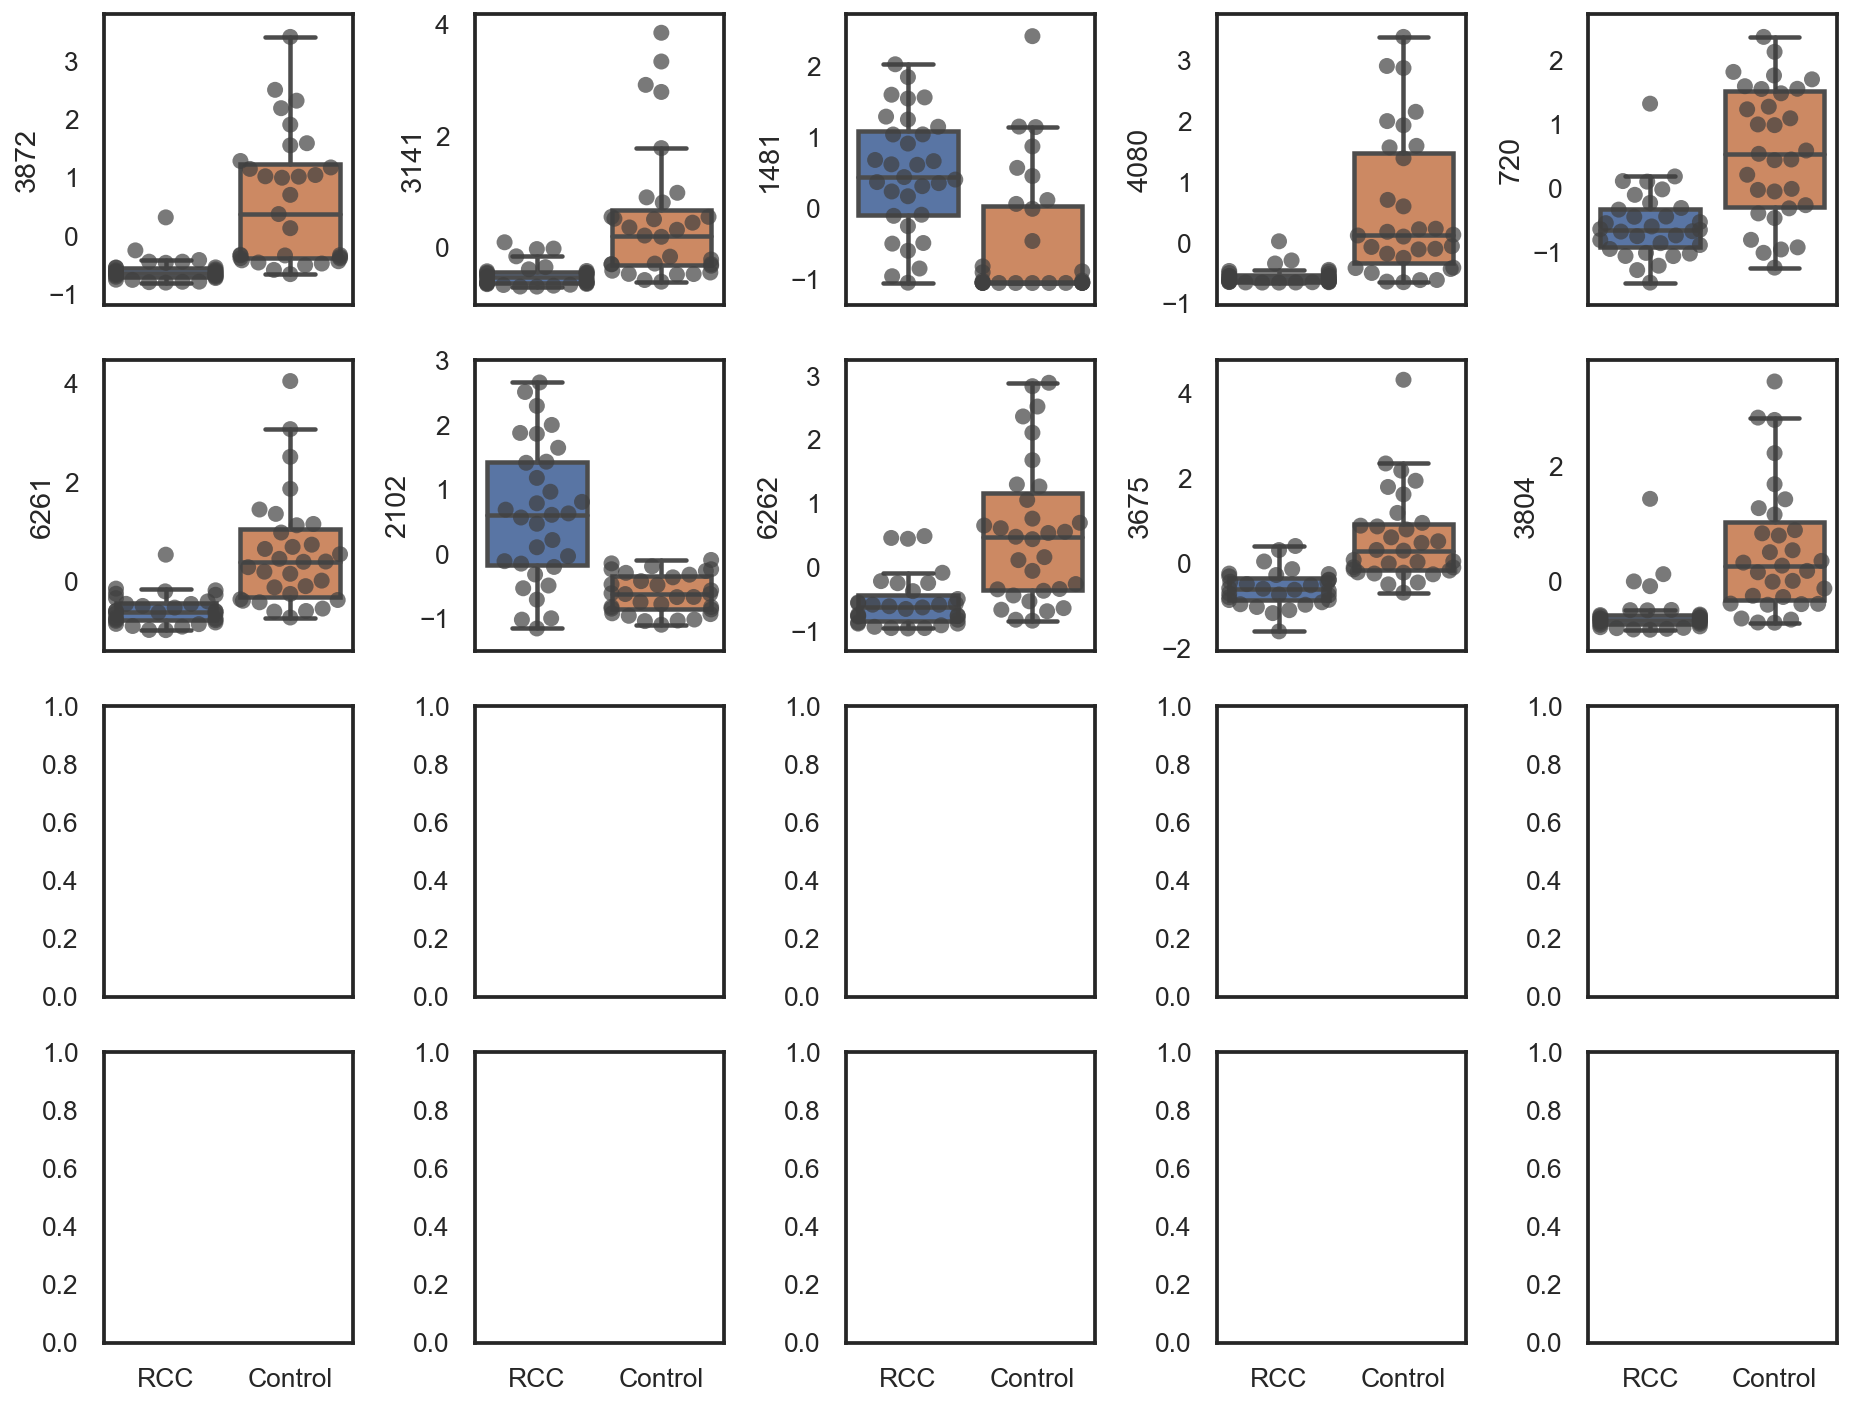

In [98]:
# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=4, ncols=5, sharex=True, figsize=(13, 10))
for idx, feat in enumerate(biomarker.columns[1:]):
    ax = axes[int(idx / 5), idx % 5]
    sns.boxplot(x='Groups', y=feat, data=biomarker, 
                ax=ax, showfliers=False)
    #sns.barplot (x='Groups', y=feat, data=df, ax=ax, capsize=.06)
    sns.swarmplot(x='Groups', y=feat, data=biomarker, 
                  ax=ax, s=8, alpha=0.7, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('AUCplots.svg', dpi=300)

#### PCA

In [99]:
def PCA_Python(X, y, scaled=True):
    '''
    FUNCTION:  
    A principle component analysis function
    Note that number of component to be picked is fixed at 2 and scaling is pareto. 
    **Edit function to make this flexible** 
    
    DEPENDENCY: sklearn
    from sklearn import decomposition
    
    INPUT: Pandas dataframe
    X: Data. Numerical.
    y: Groups
    scaled: Boolean. Default=True
   
    
    OUTPUT: figure
    A PCA score plot
    
    '''
    pca = decomposition.PCA(n_components=2)
    if scaled == True: 
        X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
        #X_centered =(X - X.mean(axis=0))/X.std(axis=0) #autoscaling
    elif scaled == False:
        X_centered = X
    
    pca.fit(X_centered)
    X_pca = pca.transform(X_centered)
    Var = pca.explained_variance_ratio_ # returns variance ratio of the selected component. 
    a = plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Control');
    b = plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'ro', label='RCC');
    c = plt.xlabel("PC1: " + str(round(Var[0]*100, 2)) + "%");
    d = plt.ylabel("PC2: " + str(round(Var[1]*100, 2))+ "%");
    e = plt.legend(loc=0);
    return (a, b, c, d, e)

PCA score plots using all ML features

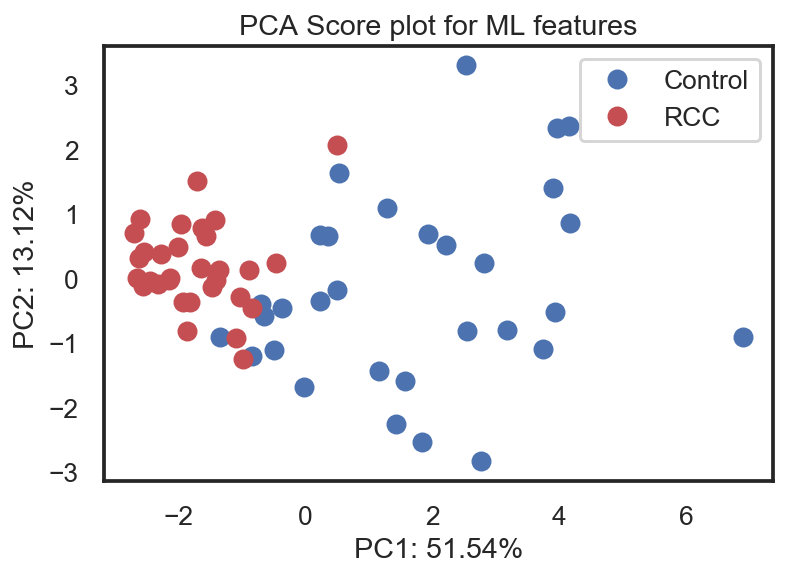

In [100]:
ylabel = biomarker['Groups'].map({'Control' : 0, 'RCC' : 1})
PCA_Python(MLfeatures, ylabel, False)
plt.title('PCA Score plot for ML features');

**Hierarchial Clustering using all ML features**

In [101]:
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

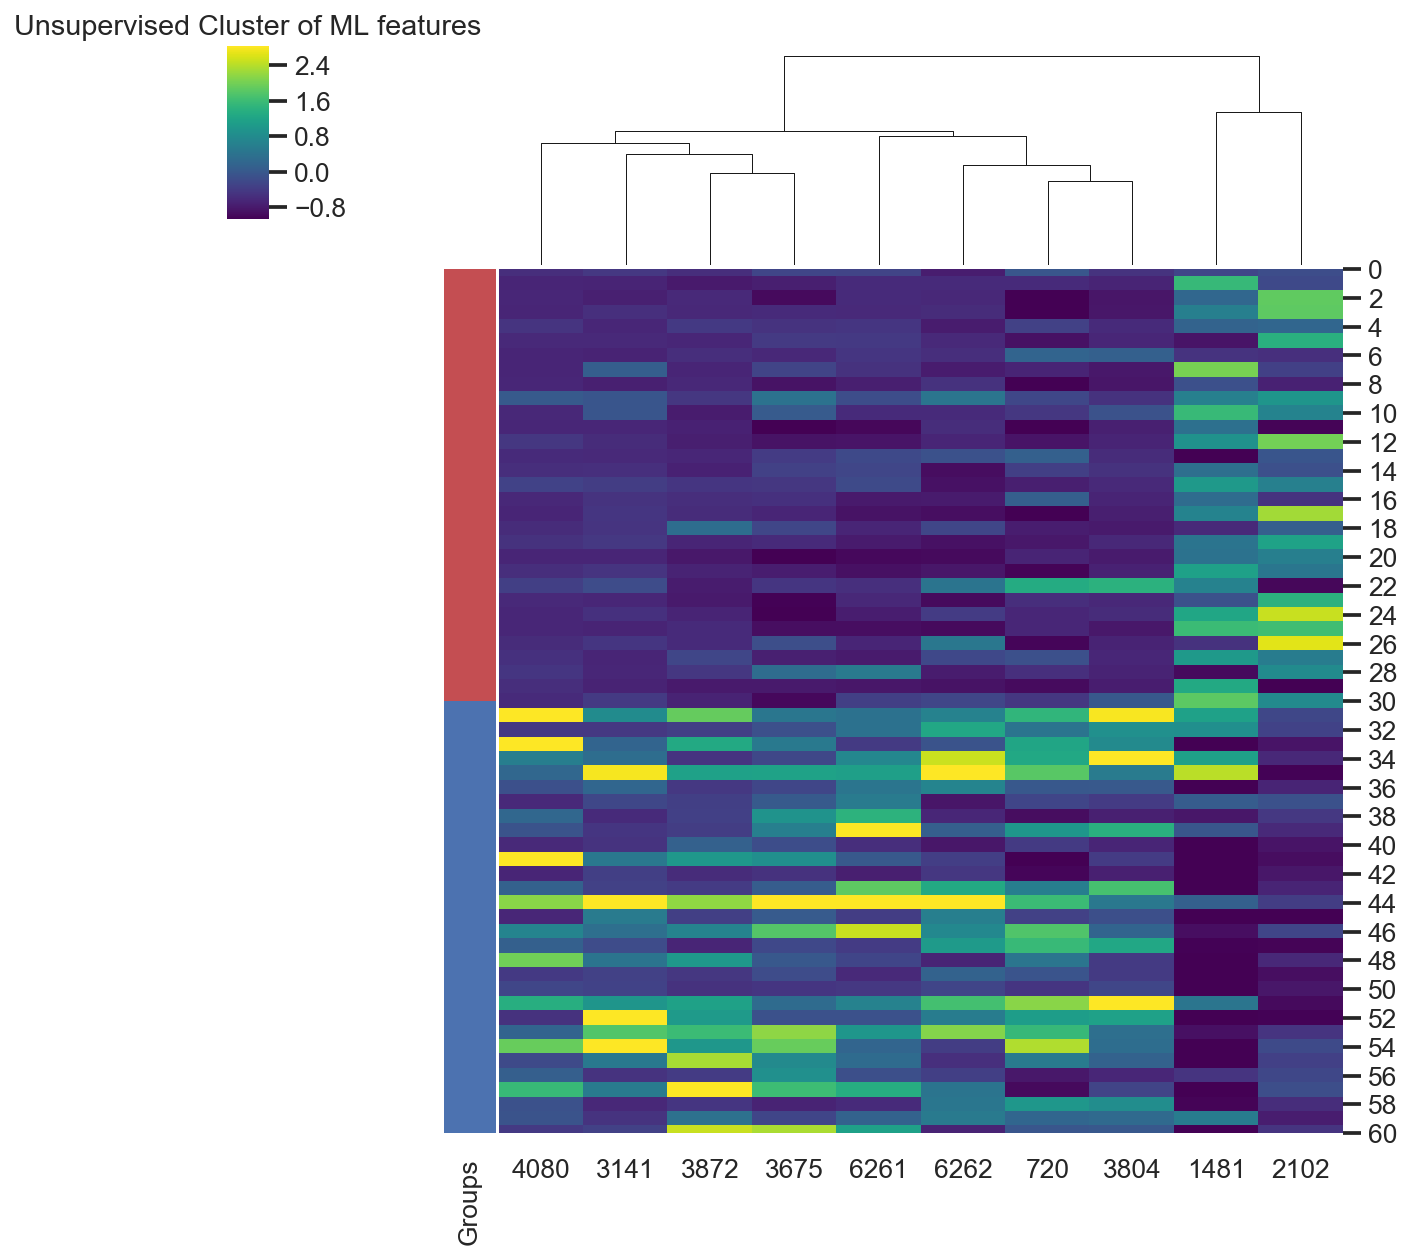

In [102]:
groups_two = biomarker.pop('Groups')
biomarker = biomarker.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(biomarker, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=False, 
                   row_colors=row_colors, robust=True);
plt.title('Unsupervised Cluster of ML features');
# define biomarker dataframe again because of the .pop method
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

**Hierarchial Clustering using features with _q_ value < 0.05**

In [103]:
Feature = stat_sig['Metabolite'].values.tolist(); # stat MS significant metabolites
qfeatures = NMRMS[Feature] # p<0.05 metabolites
qfeatures =(qfeatures - qfeatures.mean(axis=0))/qfeatures.std(axis=0) #autoscaling
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
qmarker = modelcohort.iloc[:, group_loc].to_frame().join(qfeatures)
print ('The total number of features in this DF is:', len(Feature))

The total number of features in this DF is: 435


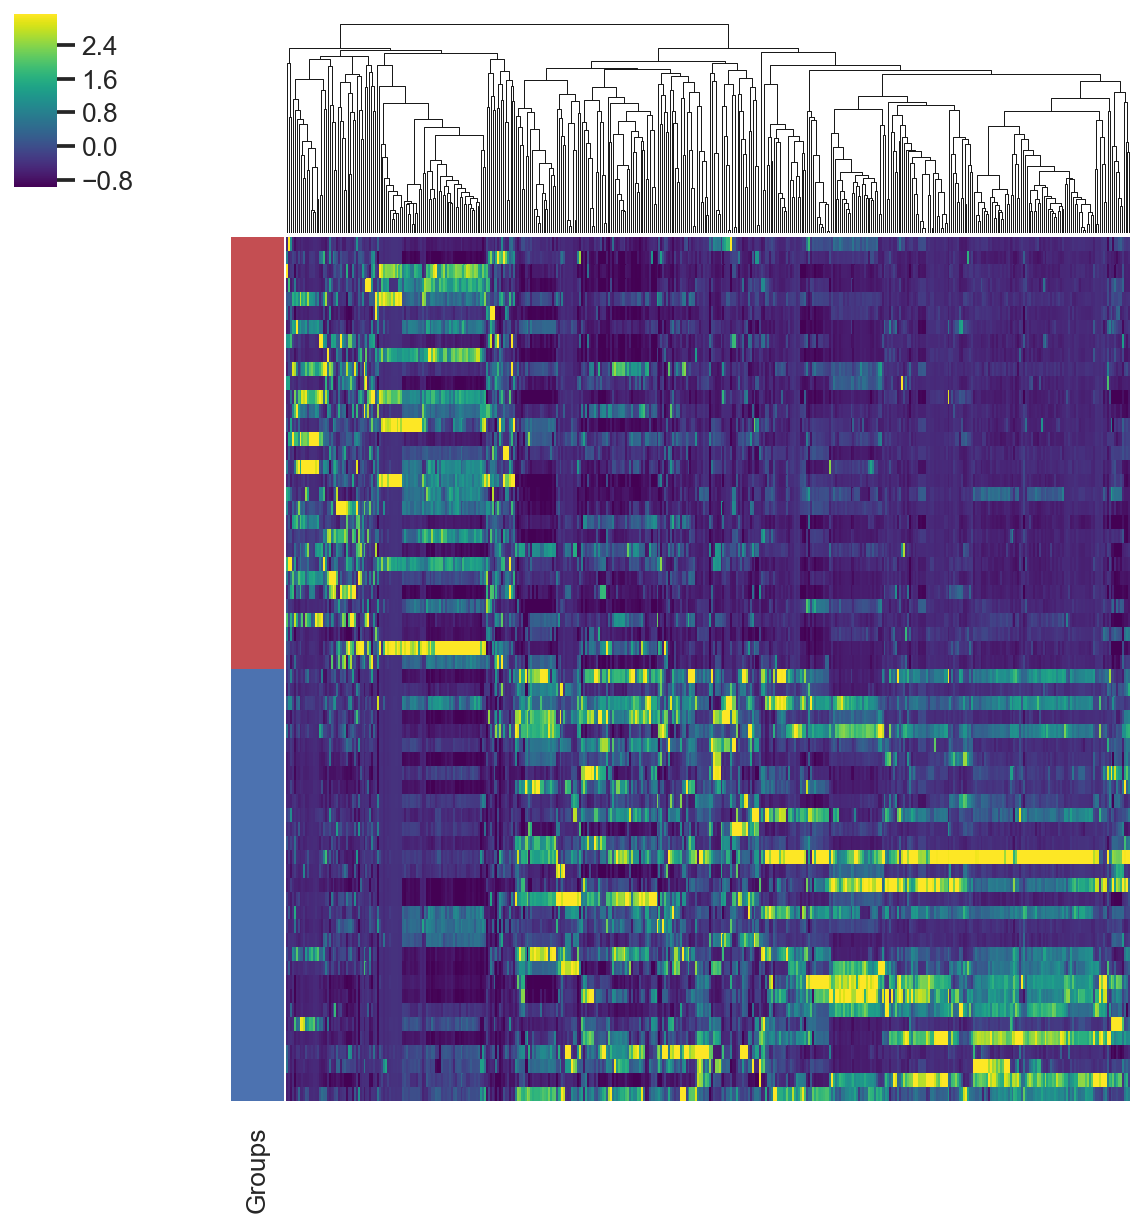

In [104]:
groups_two = qmarker.pop('Groups')
qmarker = qmarker.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
hca_qmarker = sns.clustermap(qmarker, method="weighted", 
               metric='euclidean', cmap="viridis", 
               row_cluster=False, row_colors=row_colors, 
               robust=True, xticklabels=False, 
               yticklabels=False);
#plt.title('Unsupervised Cluster of ML features');

#save figure
#hca_qmarker.savefig("hca_qmarker.svg")
# define biomarker dataframe again because of the .pop method
qmarker = modelcohort.iloc[:, group_loc].to_frame().join(qfeatures)


### [Go back to notebook content](#0)

# 2. RCC Prediction: Test Cohort
<a id="2"></a>

In [105]:
testcohort = pd.read_excel('data/testcohort.xlsx')

In [106]:
MLfeatures2 = testcohort[biomarker.iloc[:, 1:].columns]
MLfeatures2 =(MLfeatures2 - MLfeatures2.mean(axis=0))/MLfeatures2.std(axis=0) #autoscaling
MLfeatures2.shape

(194, 10)

Define features and labels.

In [107]:
dfgrp = testcohort.filter(['Groups'], axis=1)
#convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
X = MLfeatures2.values
y = dfgroup.values
print (X.shape)
print (y.shape)

(194, 10)
(194,)


### Call the tuned machine learning algorithms

In [108]:
RF

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [109]:
linsvm

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [110]:
clf

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [111]:
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=1,
                     weights='uniform')

In [112]:
#RF=RandomForestClassifier(n_estimators=100, random_state=123)
metric = ml_model(X, y, RF)
RF_AUC, RF_ACC, RF_PRE, RF_REC, RF_FS, RF_MCC, RF_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# Linear-SVM
metric = ml_model(X, y, linsvm)
linsvm_AUC, linsvm_ACC, linsvm_PRE, linsvm_REC, linsvm_FS, linsvm_MCC, linsvm_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# SVM
#clf = svm.SVC(kernel='linear', probability=True)
metric = ml_model(X, y, clf)
clf_AUC, clf_ACC, clf_PRE, clf_REC, clf_FS, clf_MCC, clf_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# KNN
metric = ml_model(X, y, knn)
KNN_AUC, KNN_ACC, KNN_PRE, KNN_REC, KNN_FS, KNN_MCC, KNN_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


**AUC**

In [113]:
sns.set_context('talk', font_scale=0.8)

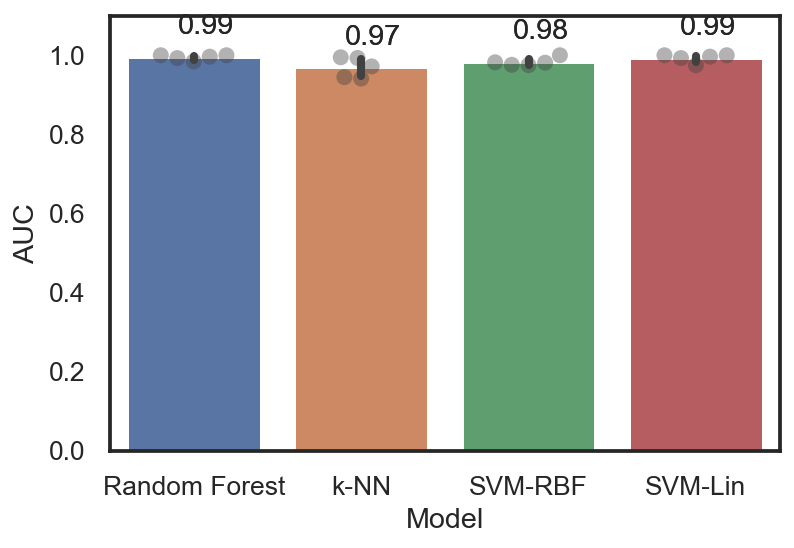

In [116]:
AUCfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'AUC':[mean(RF_AUC), mean(KNN_AUC), mean(clf_AUC), mean(linsvm_AUC)]}

afig = {'RF': RF_AUC, 'KNN': KNN_AUC, 'SVM': clf_AUC, 'Lin-SVM': linsvm_AUC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(AUCfig, 'AUC');
#plt.title('ML Model AUC Comparison for RCC prediction');

**Accuracy**

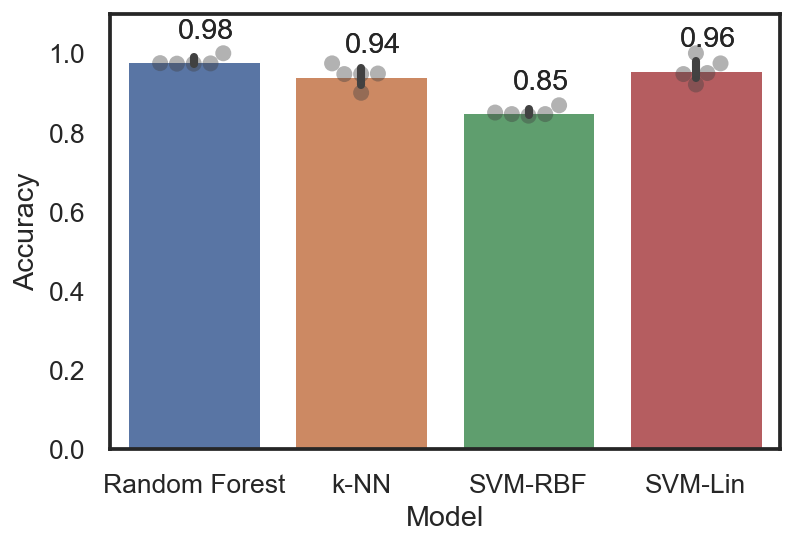

In [117]:
ACC_fig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Accuracy':[mean(RF_ACC), mean(KNN_ACC), mean(clf_ACC), mean(linsvm_ACC)]}

afig = {'RF': RF_ACC, 'KNN': KNN_ACC, 'SVM': clf_ACC, 'Lin-SVM': linsvm_ACC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(ACC_fig, 'Accuracy');
#plt.title('ML Model Accuracy Comparison for RCC prediction');

**Precision**

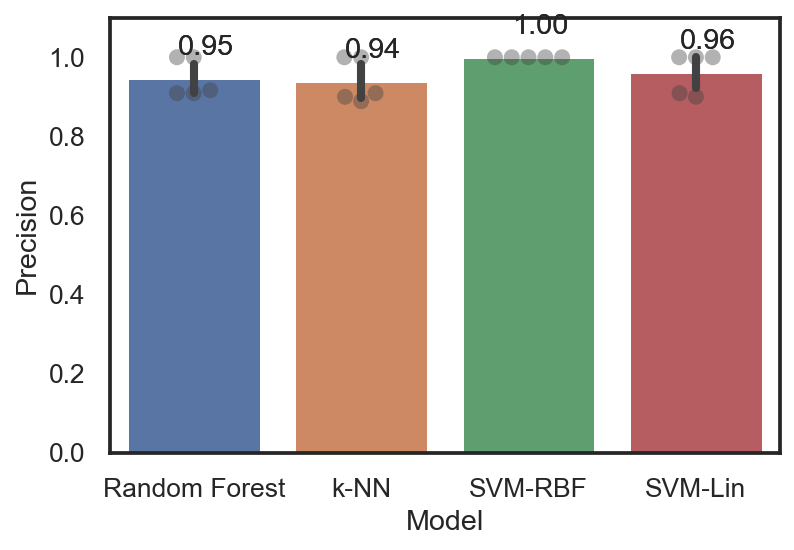

In [118]:
PREfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Precision':[mean(RF_PRE), mean(KNN_PRE), mean(clf_PRE), mean(linsvm_PRE)]}

afig = {'RF': RF_PRE, 'KNN': KNN_PRE, 'SVM': clf_PRE, 'Lin-SVM': linsvm_PRE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(PREfig, 'Precision');
#plt.title('ML Model Sensitivity (Precision) Comparison for RCC prediction');

**Recall**

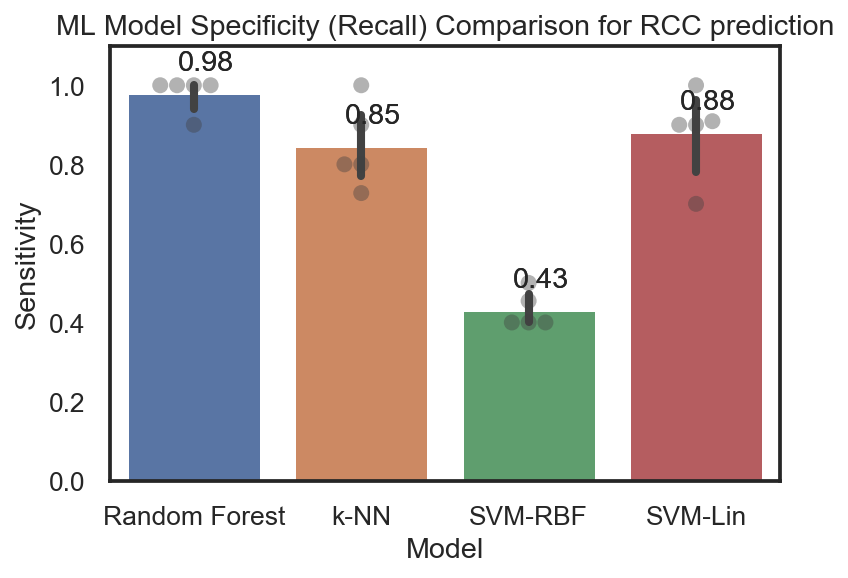

In [119]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Sensitivity':[mean(RF_REC), mean(KNN_REC), mean(clf_REC), mean(linsvm_REC)]}

afig = {'RF': RF_REC, 'KNN': KNN_REC, 'SVM': clf_REC, 'Lin-SVM': linsvm_REC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'Sensitivity');
plt.title('ML Model Specificity (Recall) Comparison for RCC prediction');

**F1 Score**

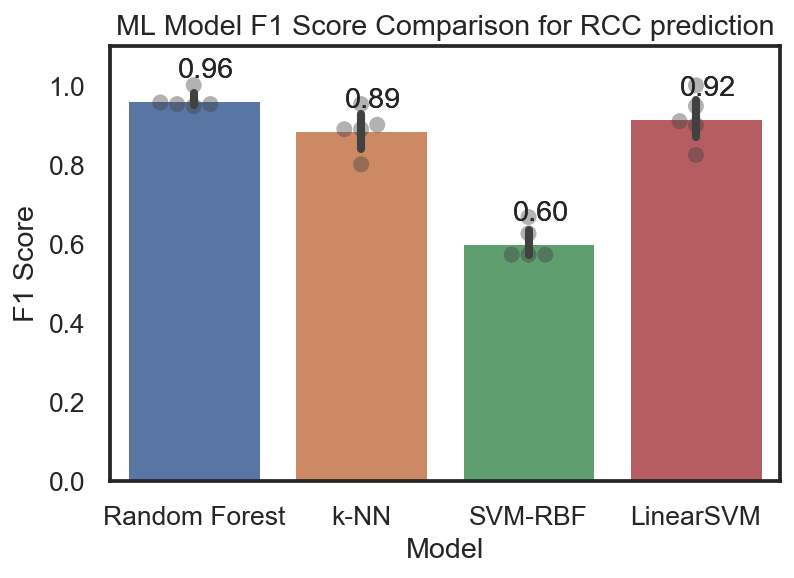

In [122]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'F1 Score':[mean(RF_FS), mean(KNN_FS), mean(clf_FS), mean(linsvm_FS)]}

afig = {'RF': RF_FS, 'KNN': KNN_FS, 'SVM': clf_FS, 'Lin-SVM': linsvm_FS}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'F1 Score');
plt.title('ML Model F1 Score Comparison for RCC prediction');

**Specificity**

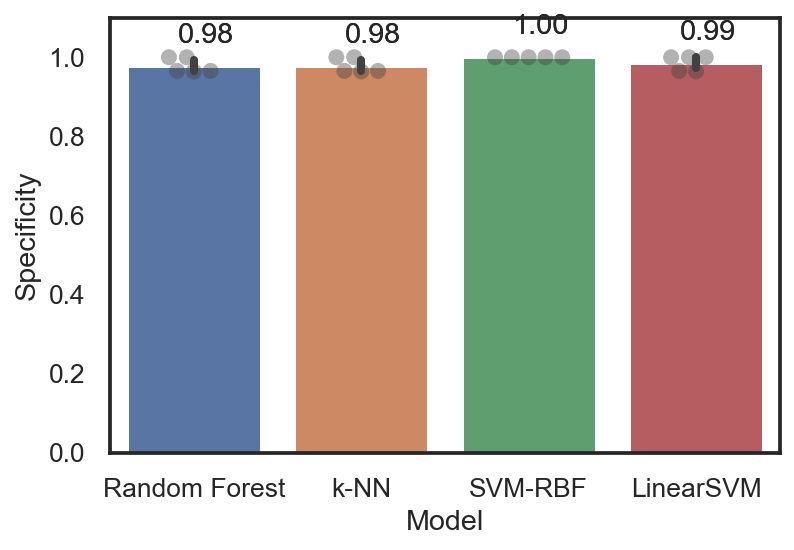

In [120]:
SPEfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'Specificity':[mean(RF_SPE), mean(KNN_SPE), mean(clf_SPE), mean(linsvm_SPE)]}

afig = {'RF': RF_SPE, 'KNN': KNN_SPE, 'SVM': clf_SPE, 'Lin-SVM': linsvm_SPE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(SPEfig, 'Specificity');
#plt.title('ML Model F1 Score Comparison for RCC prediction');

The best classifier is RF, and here are the feature importance from random forest:

In [121]:
feature_imp = pd.Series(RF.feature_importances_,
                        index=MLfeatures2.columns.astype(float)).sort_values(ascending=False)

No handles with labels found to put in legend.


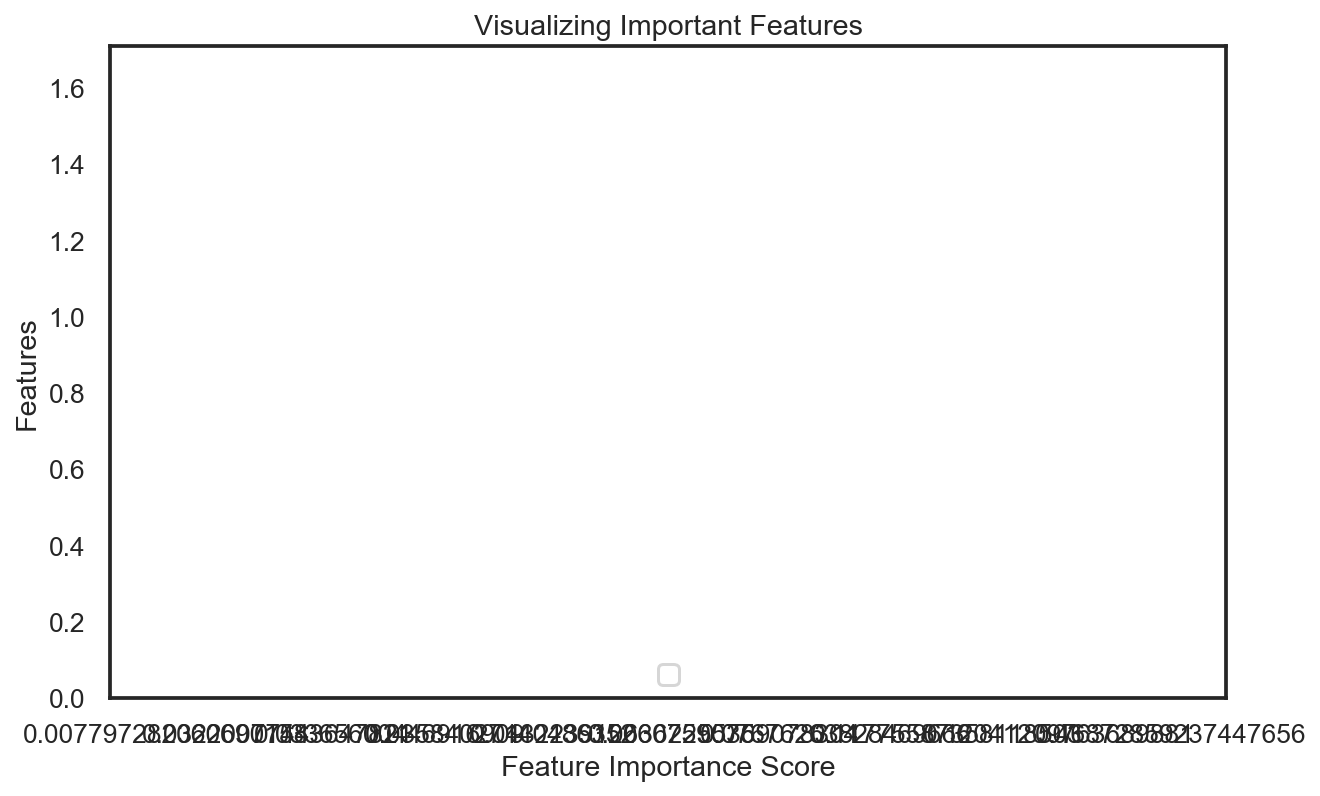

In [122]:
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
#plt.savefig('RF_Features.svg', dpi=300)
plt.show()

### Biomarkers: PCA, Hierarchical clustering and Boxplot Visualization

In [123]:
print (testcohort.shape)
print (MLfeatures2.shape)

(194, 7155)
(194, 10)


In [124]:
group_loc = testcohort.columns.get_loc("Groups") #autoscaling
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
biomarker2.shape

(194, 11)

**_T_-test for metabolic features in the test cohort**

In [125]:
# Select the metabolic feature panel for RCC
MLfeatures2 = testcohort[biomarker.iloc[:, 1:].columns]
# Get the 'group' location
group_loc = testcohort.columns.get_loc("Groups") 
# Join group with the metabolic feature panel for RCC
biomarker_TC =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
# Build biomarker dataframe for Controls and RCC
Control_TC = biomarker_TC[(biomarker_TC['Groups'] == 'Control')]
RCC_TC = biomarker_TC[(biomarker_TC['Groups'] == 'RCC')]
# drop groups from the biomarker_TC columns
biomarker_TC.drop(['Groups'], axis=1, inplace=True)

In [126]:
ttest_result2 = Ttest(biomarker_TC.columns, Control_TC, 
                      RCC_TC, alpha=0.05, var=False)
ttest_result2

Metabolite  T-test p-value   FDR p-value  Reject H0
3       4080    1.357455e-19  1.357455e-18       True
4        720    6.107402e-18  3.053701e-17       True
5       6261    1.002511e-14  3.341703e-14       True
6       2102    6.805514e-11  1.701378e-10       True
7       6262    1.956155e-10  3.912311e-10       True
8       3675    2.432332e-09  3.977101e-09       True
9       3804    2.783971e-09  3.977101e-09       True
2       1481    3.639234e-07  4.549042e-07       True
1       3141    1.074027e-06  1.193363e-06       True
0       3872    3.734687e-04  3.734687e-04       True

Boxplot

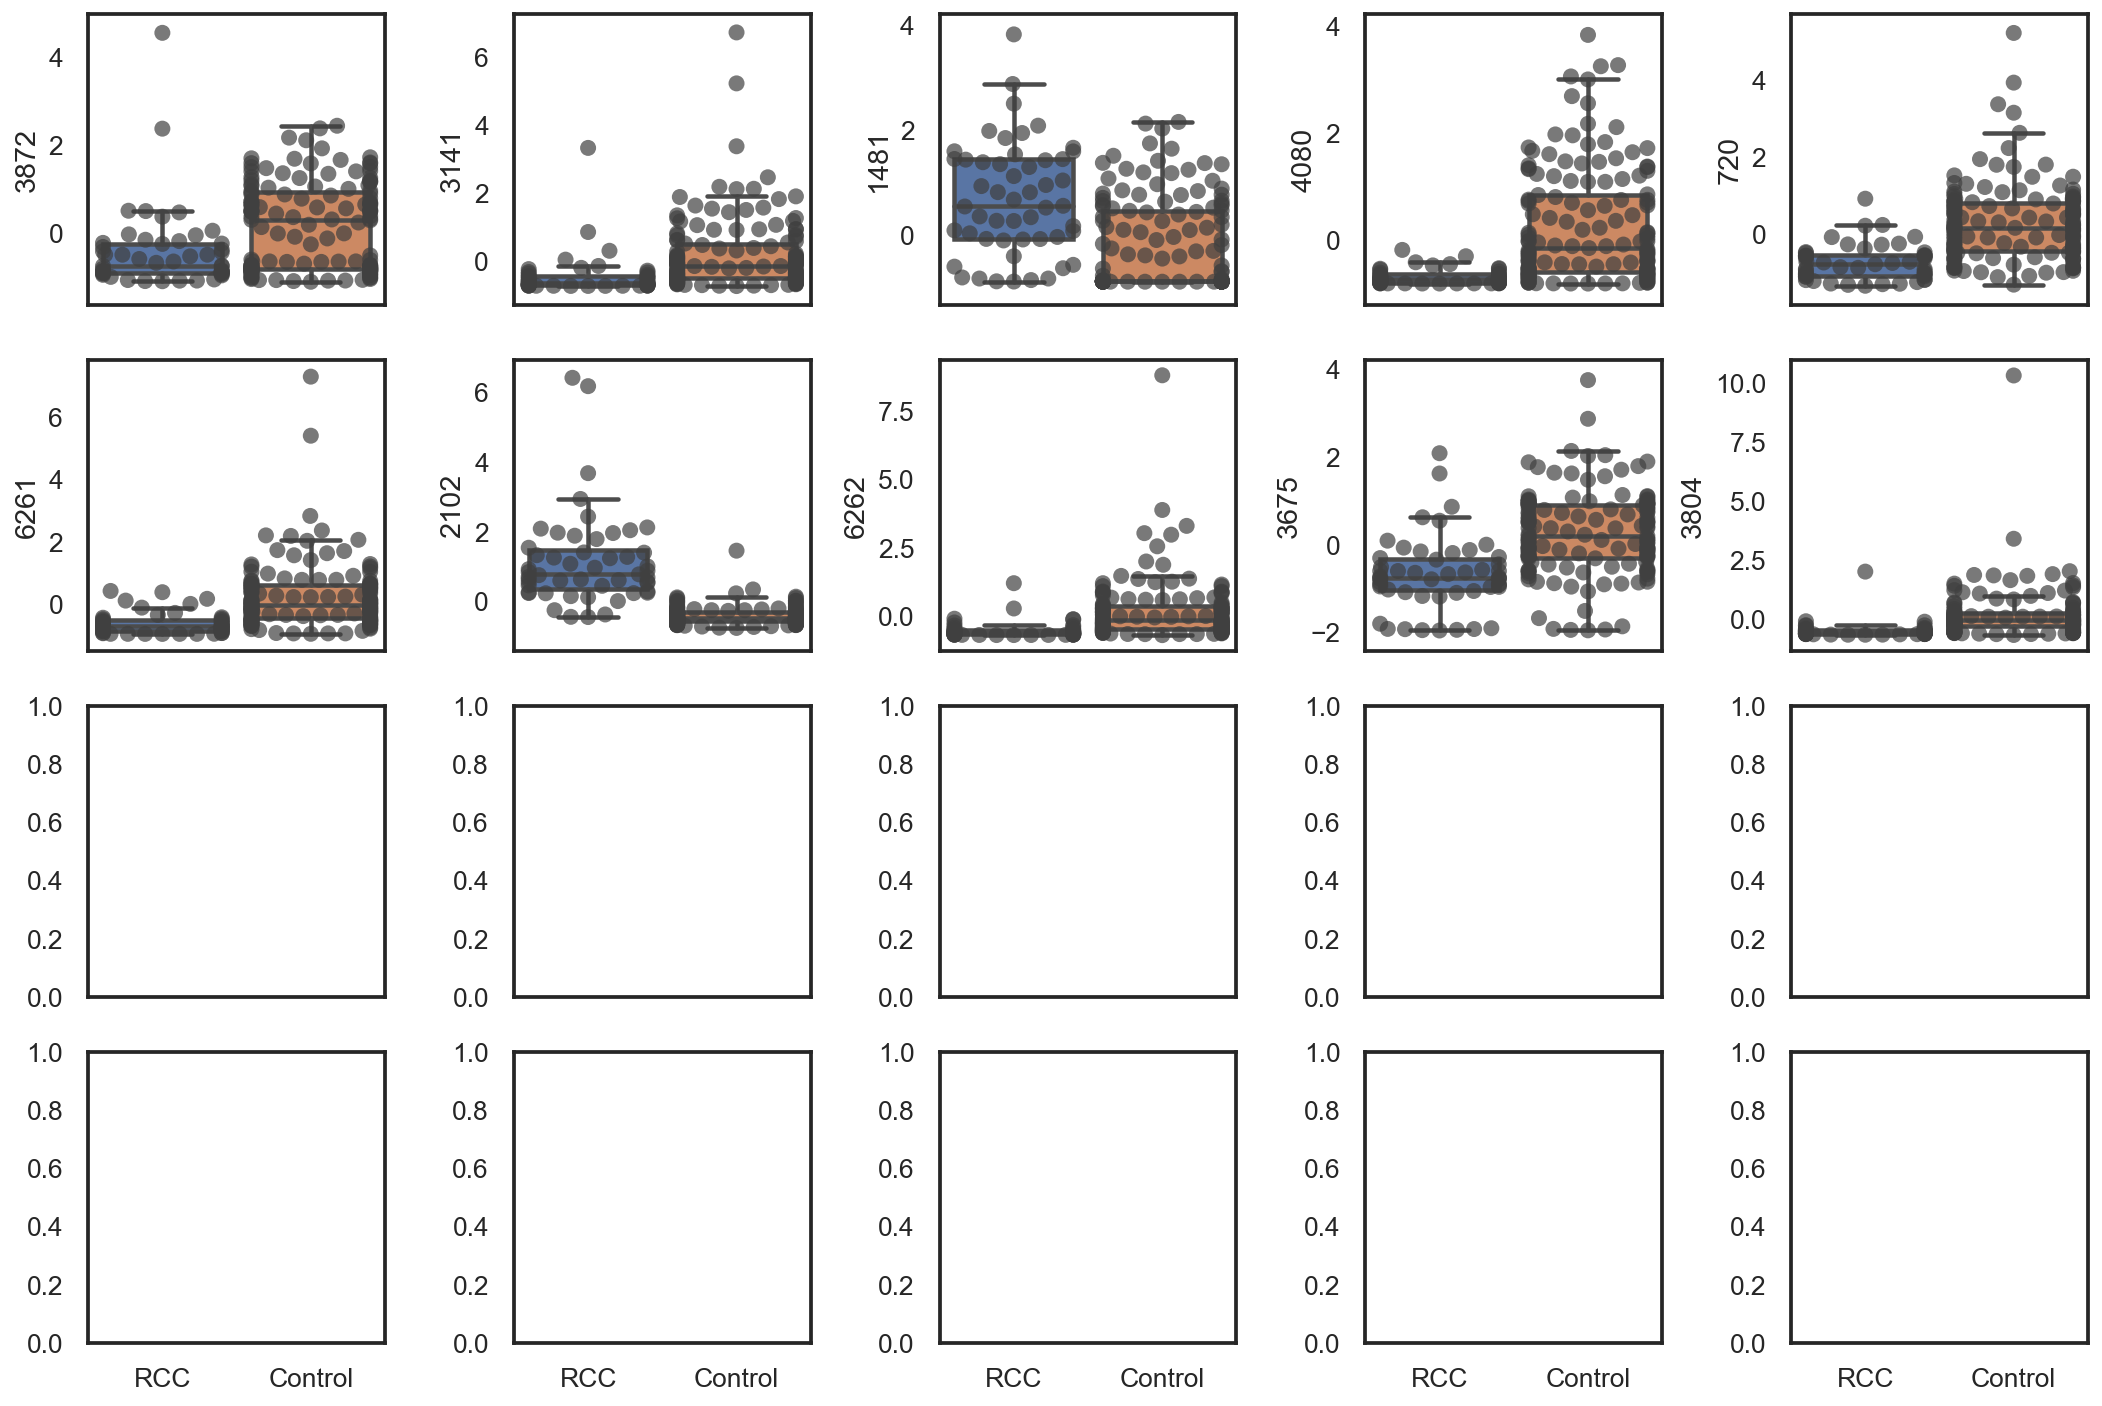

In [127]:
# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=4, ncols=5, sharex=True, figsize=(15, 10))
for idx, feat in enumerate(biomarker2.columns[1:]):
    ax = axes[int(idx / 5), idx % 5]
    sns.boxplot(x='Groups', y=feat, data=biomarker2, ax=ax, showfliers=False)
    #sns.barplot (x='Groups', y=feat, data=df, ax=ax, capsize=.06)
    sns.swarmplot(x='Groups', y=feat, data=biomarker2, 
                  ax=ax, s=8, alpha=0.7, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('AUCplots2.svg', dpi=300)

**PCA score plots using all ML features**

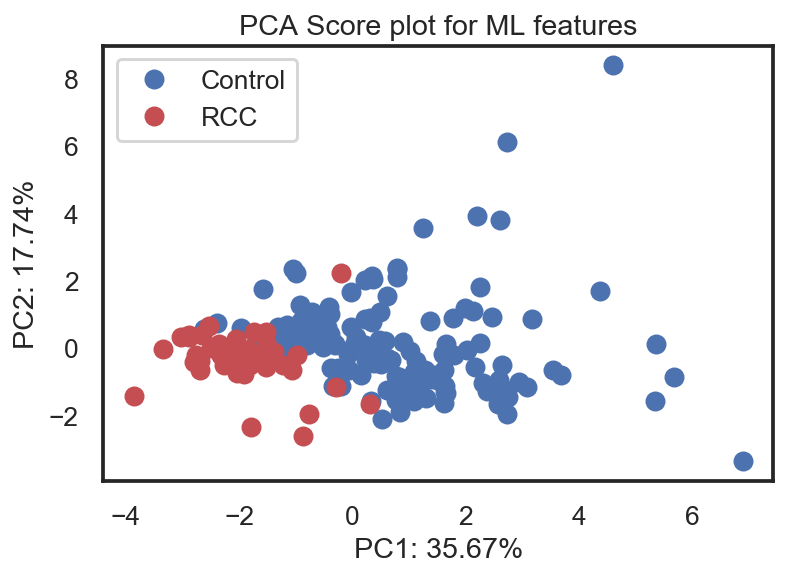

In [131]:
ylabel = biomarker2['Groups'].map({'Control' : 0, 'RCC' : 1})
MLfeatures2 =(MLfeatures2 - MLfeatures2.mean(axis=0))/MLfeatures2.std(axis=0) #autoscaling
PCA_Python(MLfeatures2, ylabel, False)
plt.title('PCA Score plot for ML features');

**Hierarchial Clustering using all ML features**

In [132]:
group_loc = testcohort.columns.get_loc("Groups") #autoscaling
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
biomarker2.shape

(194, 11)

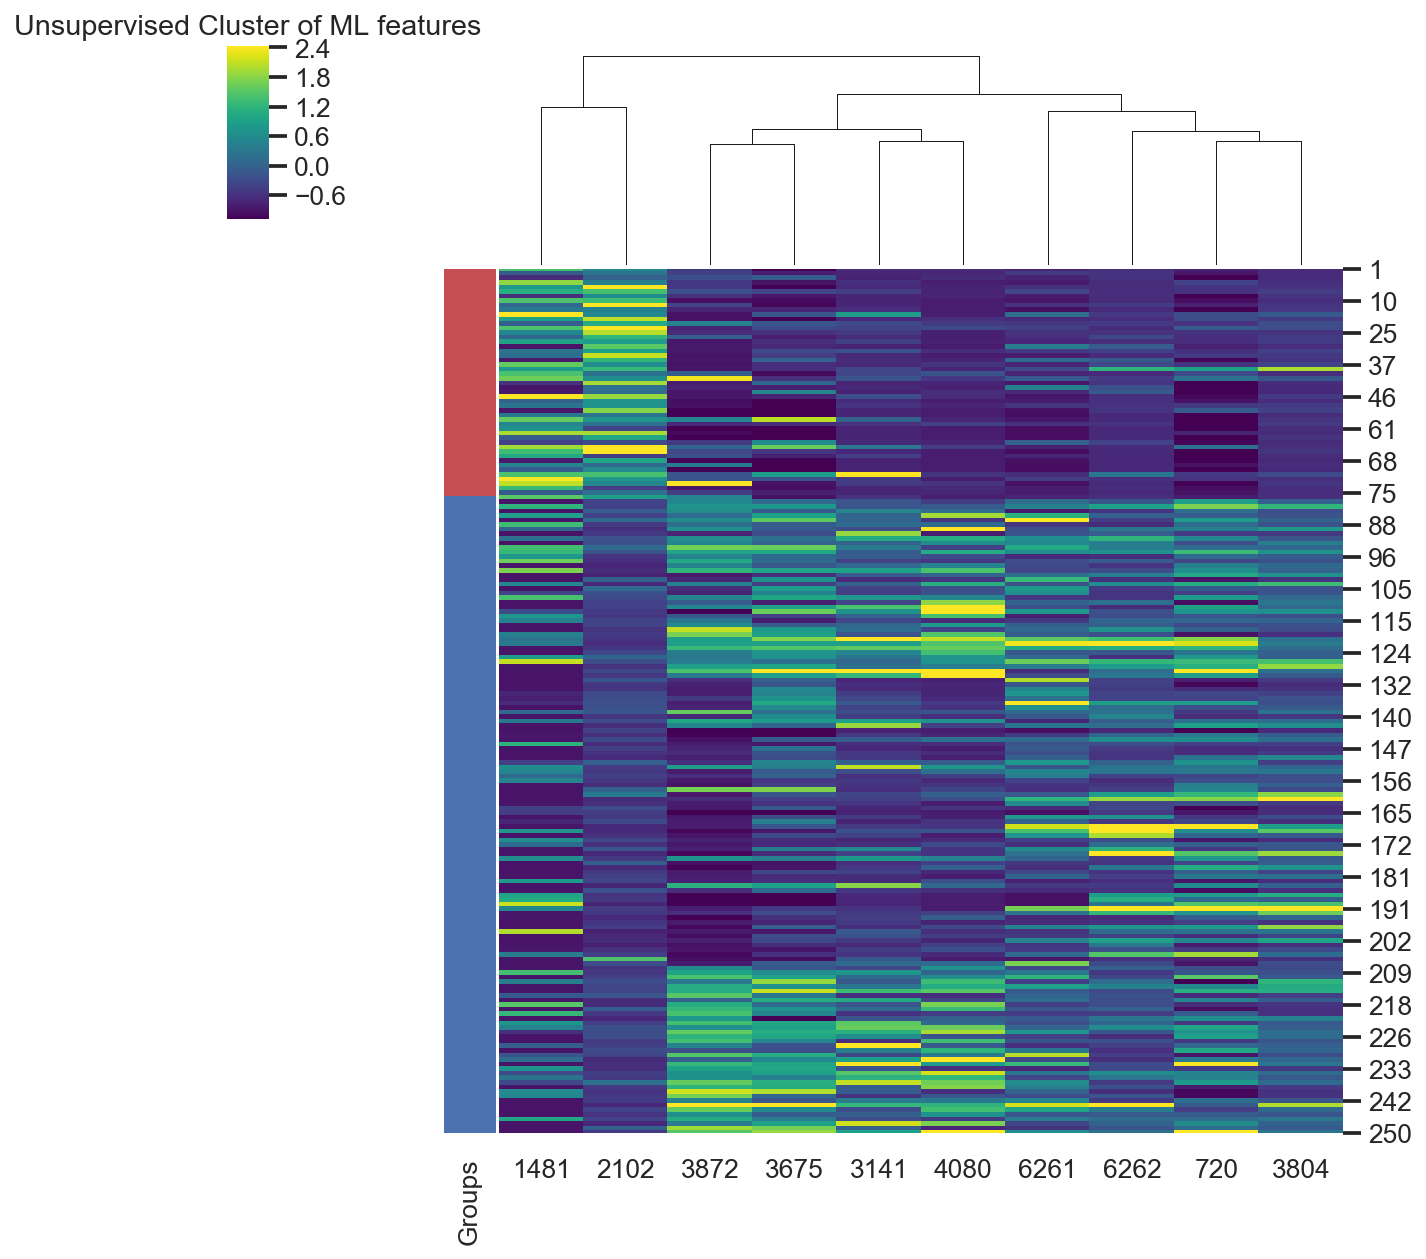

In [133]:
groups_two = biomarker2.pop('Groups')
biomarker2 = biomarker2.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(biomarker2, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=False, 
                   row_colors=row_colors, robust=True);
plt.title('Unsupervised Cluster of ML features');
# define biomarker dataframe again because of the .pop method
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)

### [Go back to notebook content](#0)

# 3. Chemical Information of Biomarkers
<a id="3"></a>

In [134]:
MS_labels_bmarkers = MS_labels[MS_labels.ID.isin(MLfeatures.columns)]
print(MS_labels_bmarkers.shape)
MS_labels_bmarkers

(10, 5)


ID      Mode  RT [min]                                 Name  \
719    720  positive     2.562  2-Aminoacetophenone;O-Acetylaniline   
1480  1481  positive     6.290                                 1481   
2101  2102  positive     3.449    N,N-Diisopropylethylamine (DIPEA)   
3140  3141  positive     1.133                                 3141   
3674  3675  positive     1.184                                 3675   
3803  3804  positive     2.595                                 3804   
3871  3872  positive     4.049                                 3872   
4079  4080  positive     0.821                                 4080   
6260  6261  negative     2.591                                 6261   
6261  6262  negative     2.667                                 6262   

                 Formula  
719            C8 H9 N O  
1480                 NaN  
2101            C8 H19 N  
3140      C7 H18 N8 O6 S  
3674                 NaN  
3803       C4 H12 N O6 P  
3871                 NaN  
4079  C10 H21 N3 O8 P2 S  
6260      C9 H18 N9 O2 P  
6261     C10 H20 N9 O5 P

In [135]:
MS_labels_qmarkers = MS_labels[MS_labels.ID.isin(qfeatures.columns)]
print(MS_labels_qmarkers.shape)
MS_labels_qmarkers.head()

(433, 5)


ID      Mode  RT [min]                                  Name  \
0      1  positive     2.317                                     1   
8      9  positive     1.901  5-Acetylamino-6-amino-3-methyluracil   
94    95  positive     1.898      3-(1H-1,2,4-Triazol-3-yl)alanine   
146  147  positive     2.580                                   147   
162  163  positive     2.654                           Venlafaxine   

             Formula  
0                NaN  
8       C7 H10 N4 O3  
94       C5 H8 N4 O2  
146  C33 H41 N O6 P2  
162     C17 H27 N O2

MS_labels_bmarkers.to_excel('RCC_20features.xlsx')

MS_labels_qmarkers.to_excel('RCC_472features.xlsx')